# 📌— Time-Series Data —

Before we will dive into the code section, we have to understand the problem comprehensively.
 
Task description from Dataset as attached!.

- To predict 3 months of item-level sales data at different store locations.
- Dataset: daily, 2013-2017 time span, 500 time series (10 stores x 50 items), sales per (store, item, date)

### 1.Install and Import Packages

In [1]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [2]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### 2. Load Data

In [3]:
!pwd


/home/nsamaira


In [3]:
train_df = pd.read_csv("framee17/demand-forecasting/data/train.csv")
test_df = pd.read_csv("framee17/demand-forecasting/data/test.csv")

In [ ]:
# test_df = pd.read_csv("framee17/demand-forecasting/data/test.csv")

In [4]:
train_df

date  store  item  sales
0       2013-01-01      1     1     13
1       2013-01-02      1     1     11
2       2013-01-03      1     1     14
3       2013-01-04      1     1     13
4       2013-01-05      1     1     10
...            ...    ...   ...    ...
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

[913000 rows x 4 columns]

In [7]:
test_df

id        date  store  item
0          0  2018-01-01      1     1
1          1  2018-01-02      1     1
2          2  2018-01-03      1     1
3          3  2018-01-04      1     1
4          4  2018-01-05      1     1
...      ...         ...    ...   ...
44995  44995  2018-03-27     10    50
44996  44996  2018-03-28     10    50
44997  44997  2018-03-29     10    50
44998  44998  2018-03-30     10    50
44999  44999  2018-03-31     10    50

[45000 rows x 4 columns]

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


The data is daily, so verify there's a record for every single day for each (store, item) pair. If any days are missing per series → use .asfreq('D') with forward fill or imputation.

In [4]:
train_df['date'] = pd.to_datetime(train_df['date'])
full_range = pd.date_range(train_df['date'].min(), train_df['date'].max(), freq='D')
full_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=1826, freq='D')

In [5]:
expected = pd.MultiIndex.from_product(
    [test_df['date'].unique(), train_df['store'].unique(), train_df['item'].unique()],
    names=["date", "store", "item"]
)
actual = test_df.set_index(["date", "store", "item"]).index

missing = expected.difference(actual)

print(f"Missing combinations in test_df: {len(missing)}")


Missing combinations in test_df: 0


In [6]:
test_df['date'] = pd.to_datetime(test_df['date'])

In [47]:
# ตรวจสอบ freq ว่า daily จริง
print(pd.infer_freq(train_df['date'].sort_values().unique()))  # ควรได้ 'D'
print(pd.infer_freq(test_df['date'].sort_values().unique()))  # ควรได้ 'D'

D
D


Null recheck

In [10]:
train_df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [44]:
test_df.isnull().sum()

id       0
date     0
store    0
item     0
dtype: int64

### 3.EDA

Plot total sales for each Iteam across all stores combined

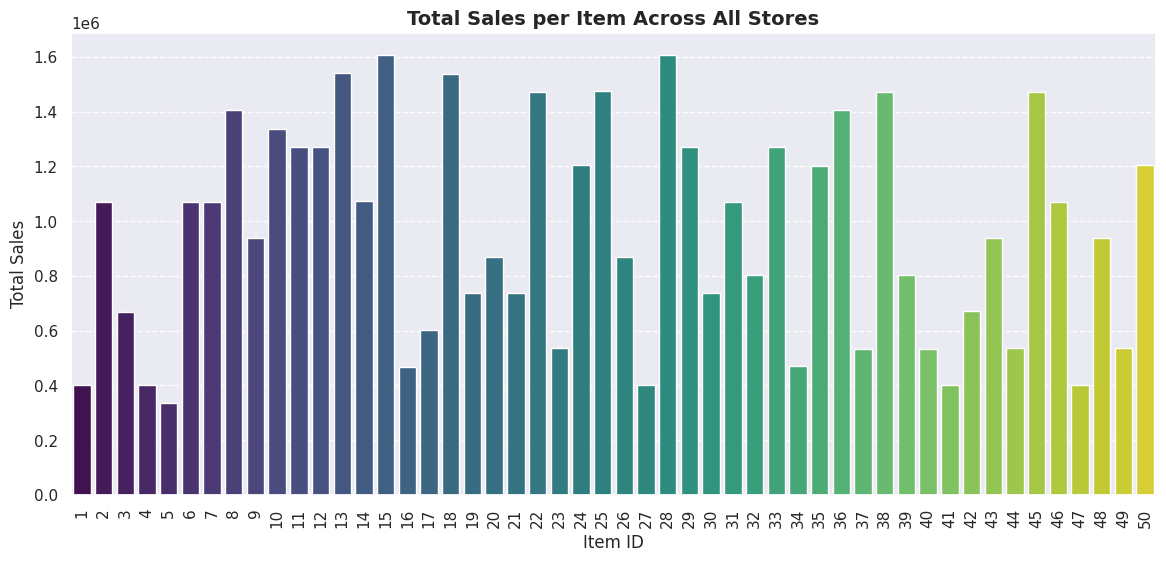

In [11]:
# Aggregate sales per item across all stores
item_sales = train_df.groupby('item')['sales'].sum().reset_index()

# Sort items by total sales
item_sales = item_sales.sort_values(by='sales', ascending=False)

sns.set_theme(style="darkgrid")
plt.figure(figsize=(14, 6))
sns.barplot(x=item_sales['item'], y=item_sales['sales'], palette="viridis")
plt.xlabel("Item ID", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.title("Total Sales per Item Across All Stores", fontsize=14, fontweight="bold")
plt.xticks(rotation=90)  

plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

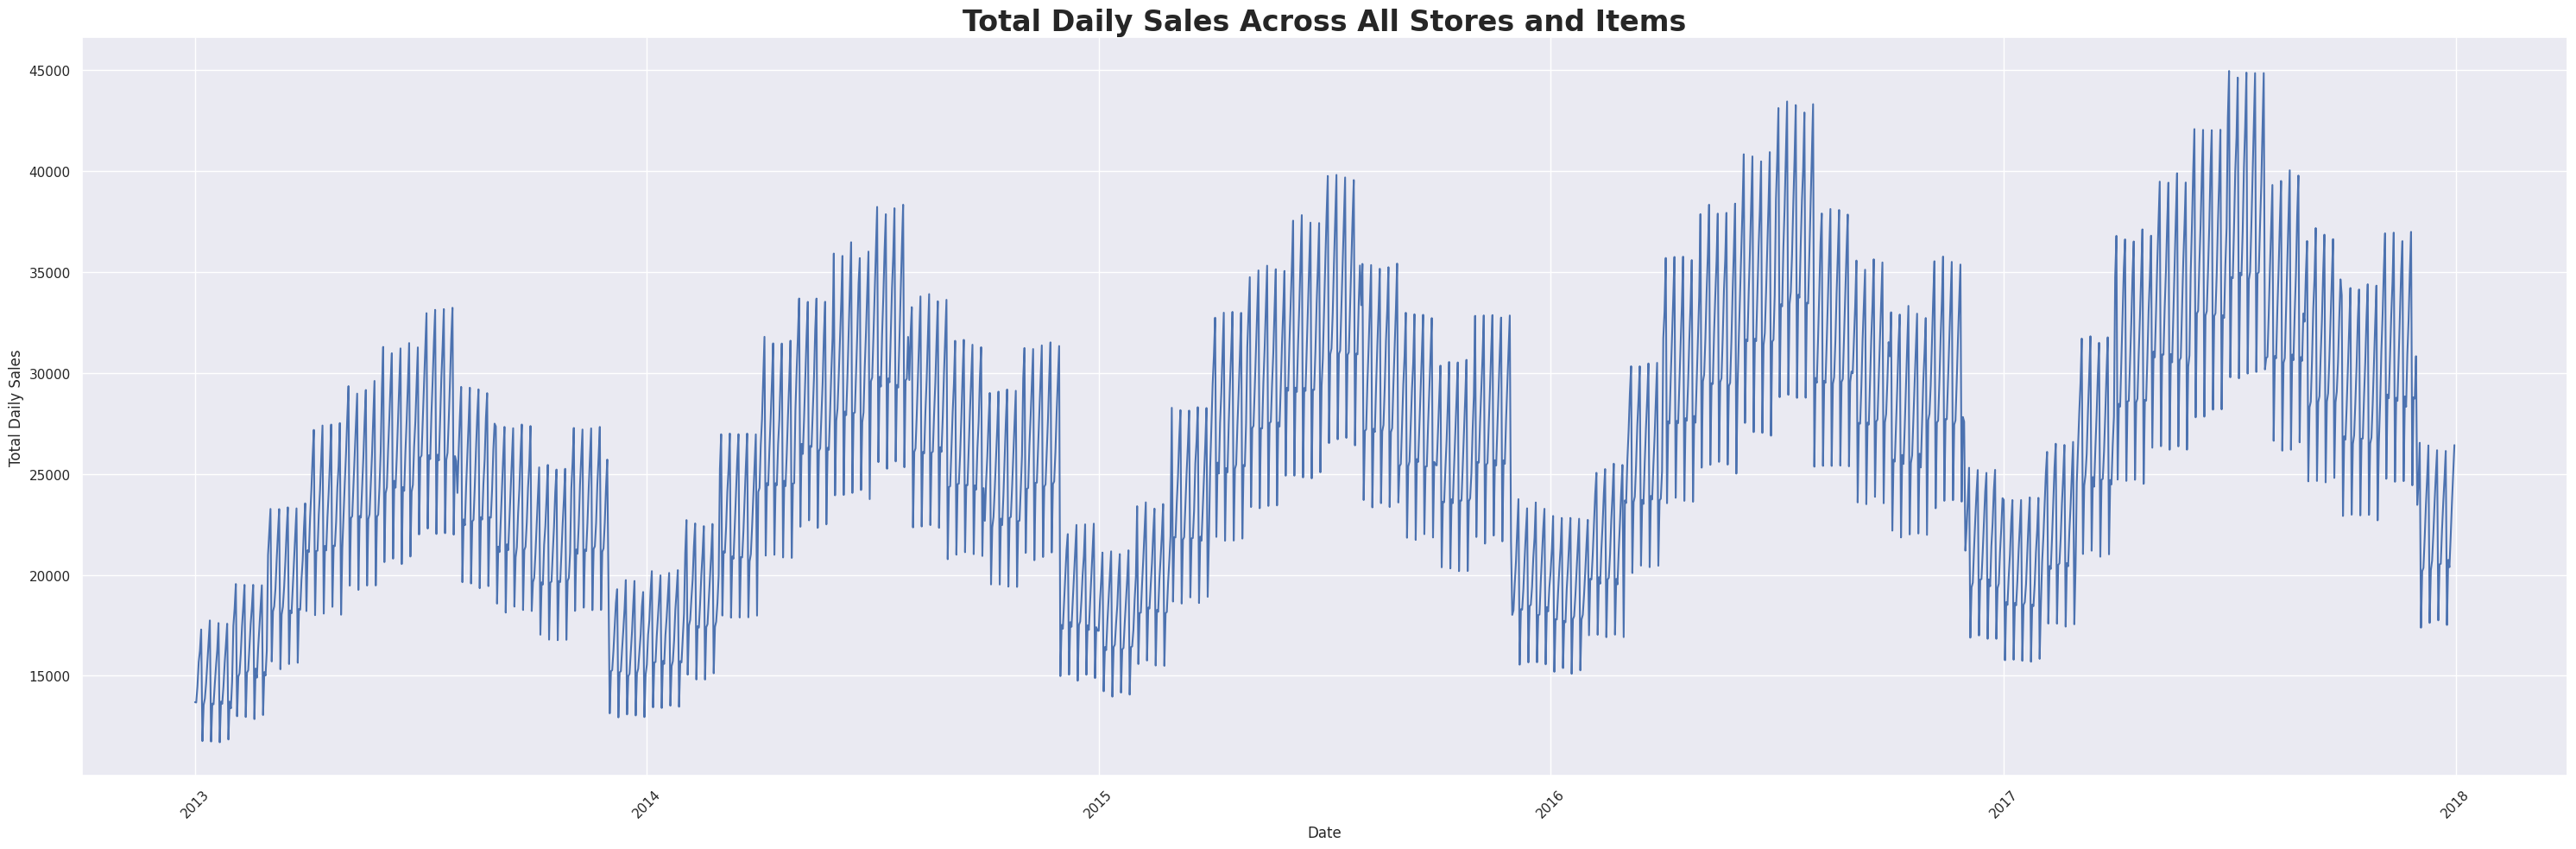

In [ ]:
# Plot the time series
daily_totals = train_df.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(30, 10))
sns.lineplot(data=daily_totals, x='date', y='sales')
plt.xlabel('Date')
plt.ylabel('Total Daily Sales')
plt.title('Total Daily Sales Across All Stores and Items',fontsize=24, fontweight="bold")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

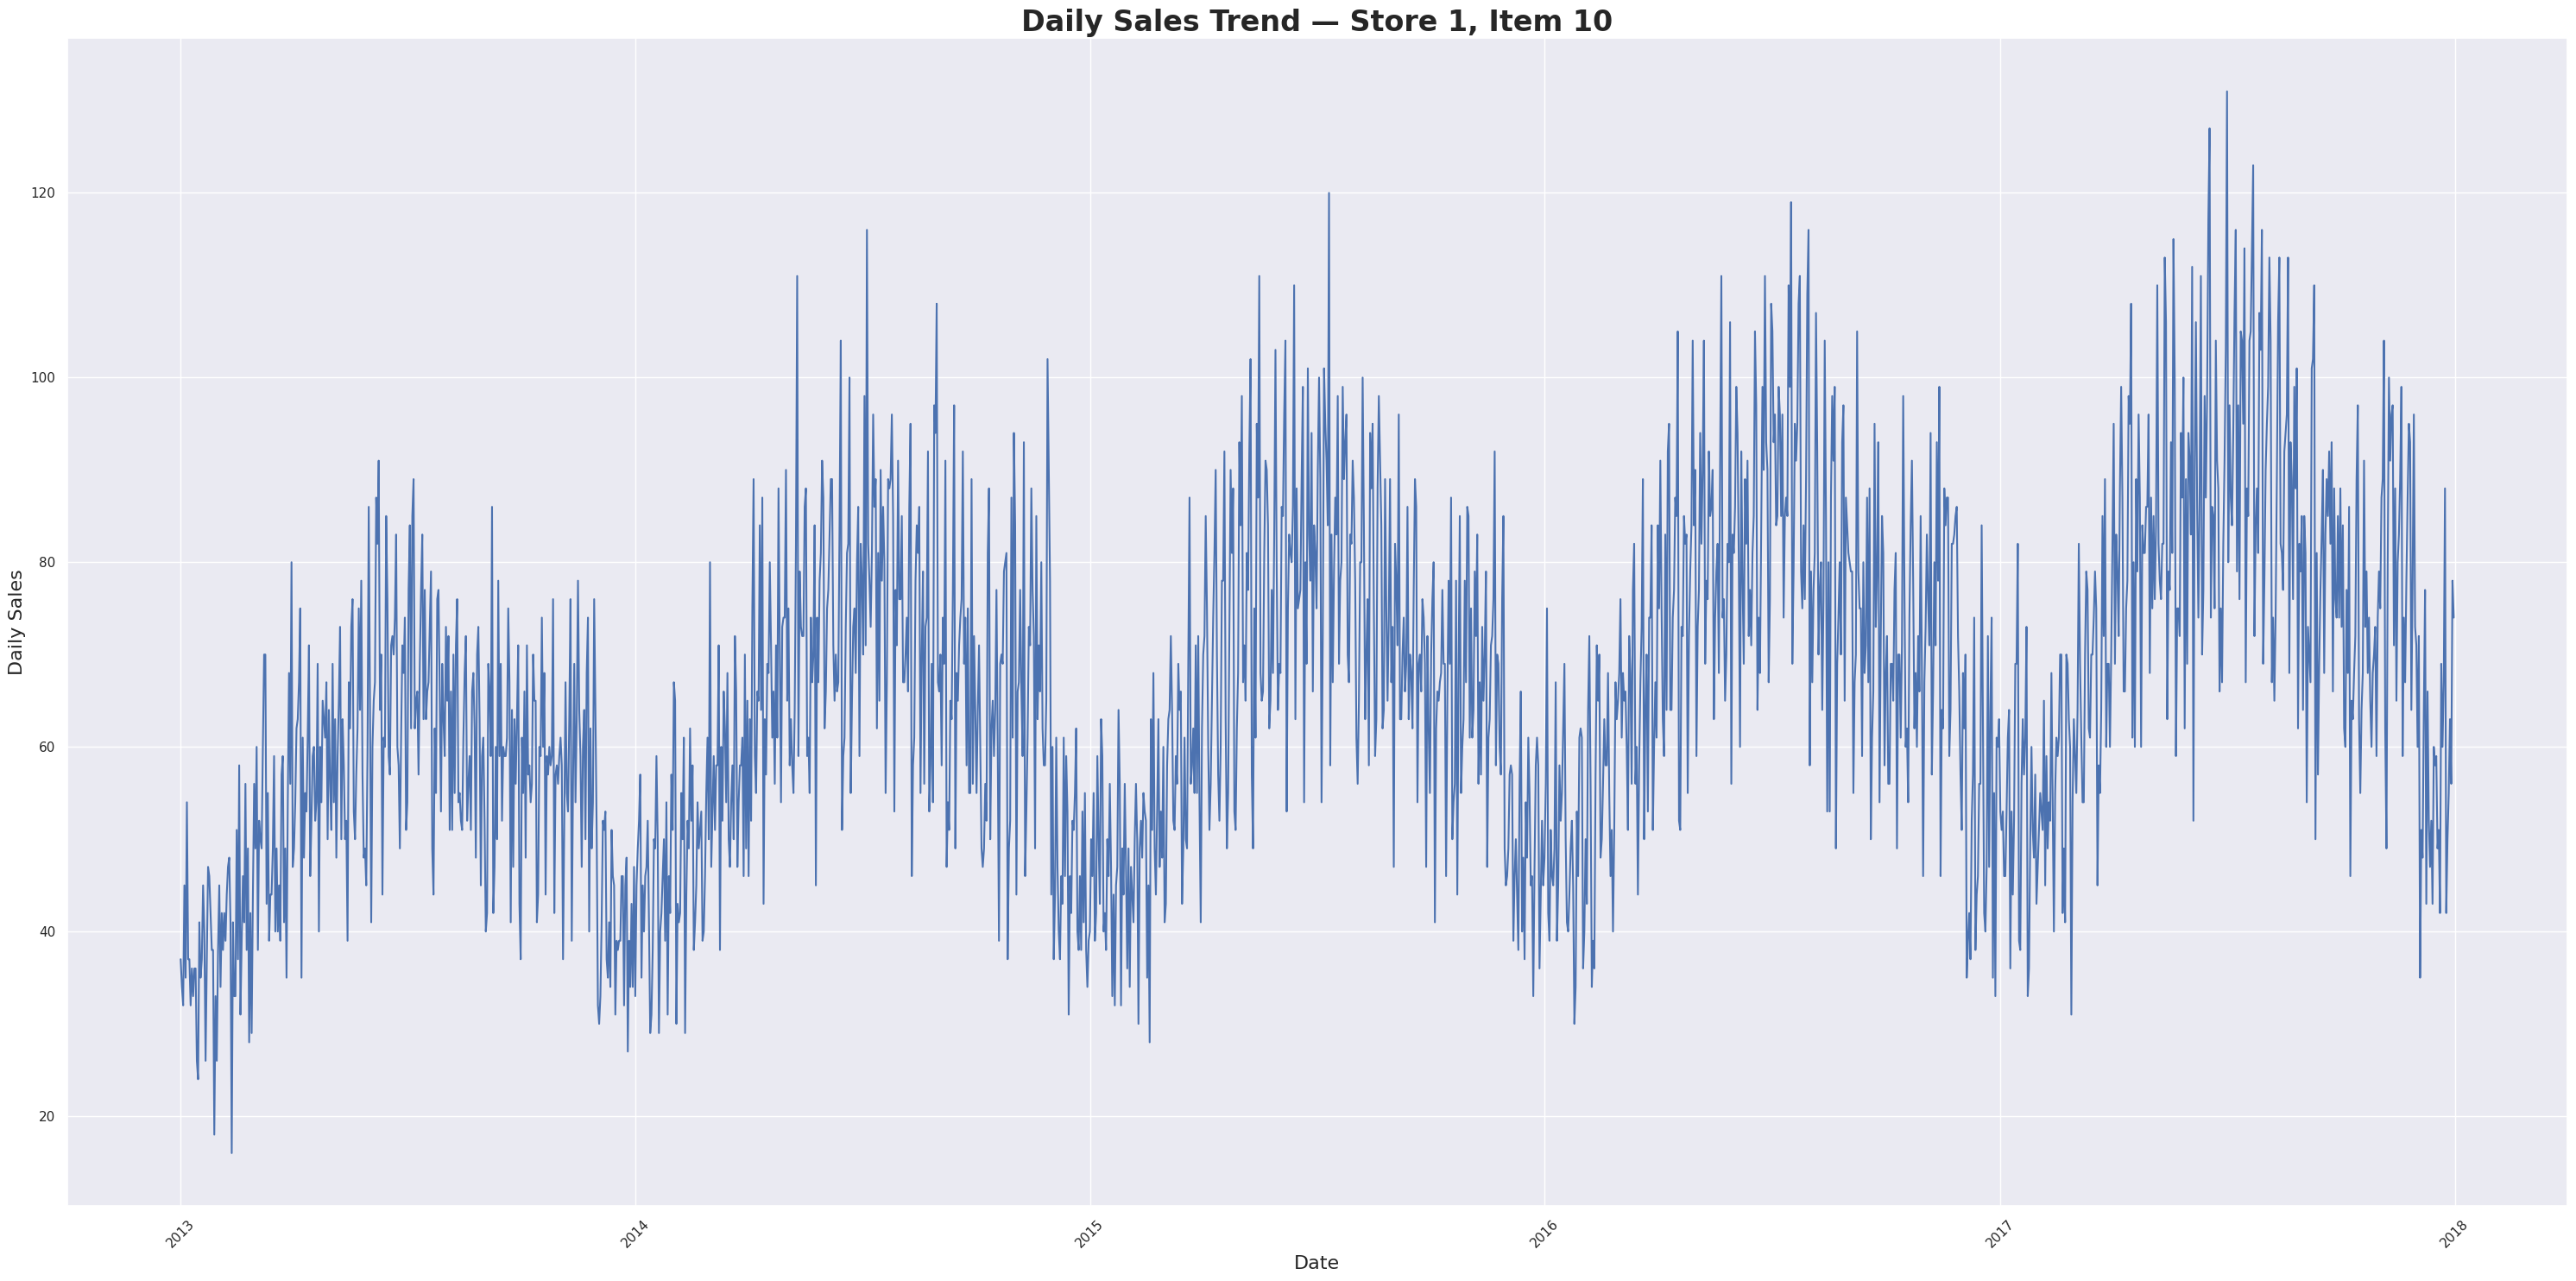

In [15]:
## ADJUST
## ------------------------
store_idx = 1
item_idx = 10

# Filter to a specific time series
subset = train_df[(train_df['store'] == store_idx) & (train_df['item'] == item_idx)].copy()
subset = subset.sort_values('date')

# Plot the daily sales time series
plt.figure(figsize=(30, 15))
sns.lineplot(data=subset, x='date', y='sales')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Daily Sales', fontsize=16)
plt.title(f"Daily Sales Trend — Store {store_idx}, Item {item_idx}", fontsize=24, fontweight="bold")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.White Noise Test 
White Noise = Time Series ที่ “ไม่มีลำดับเหตุการณ์ใด ๆ ที่เดาได้” = “pure randomness” 

 Characteristics of White Noise
- Mean = 0 -> ค่าเฉลี่ยเช้าใกล้ 0
- Constant Variance
- No autocorrelation ค่าในอดีตไม่มีผลต่อค่าปัจจุบัน (ACF = 0 ทุก lag)
- ไม่มี Seasonality, Trend, Pattern = พฤติกรรมไม่วนซ้ำหรือมีแนวโน้ม

 Why it's matters? 
if my time series is white noise so
- ต้องพิจารณาใช้โมเดลแบบ probabilistic หรือ skip forecasting แทน
- ARIMA/SARIMA จะ overfit 
- ทำนายไม่ได้

1. ดู ACF Plot
    - ถ้า ACF ≈ 0 เกือบทุก lag → อาจเป็น white noise
2. Ljung-Box Test (ทางสถิติ)

    - if p-value < 0.05 ❌ Reject H0 → ไม่ใช่ white noise (ดี!)
    - if p-value > 0.05 ✅ Accept H0 → เป็น white noise (สุ่มเกินไป ใช้ไม่ได้!)

### Define Time series

In [8]:
time_series =train_df["sales"]
time_series

0         13
1         11
2         14
3         13
4         10
          ..
912995    63
912996    59
912997    74
912998    62
912999    82
Name: sales, Length: 913000, dtype: int64

### PACF/ACF

In [ ]:
# !pip show statsmodels
!pip install statsmodels

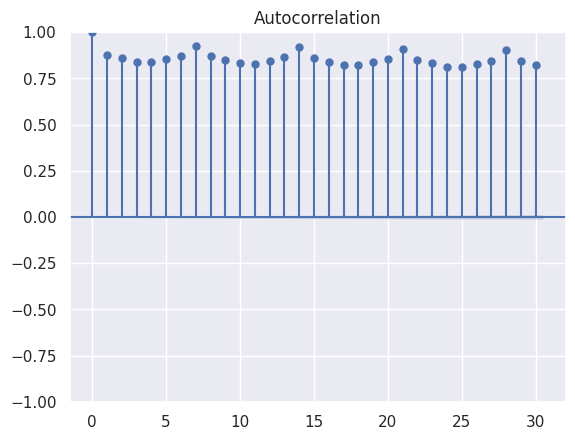

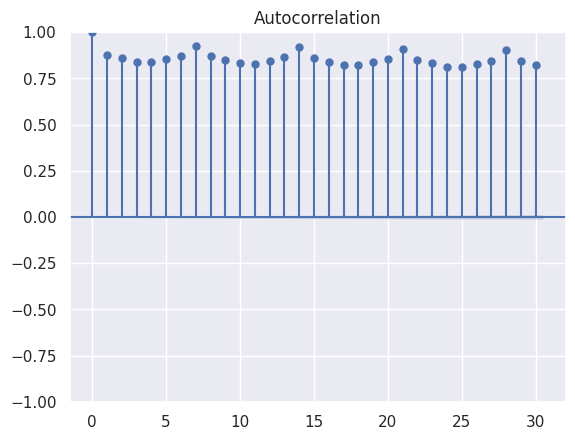

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(time_series, lags=30)

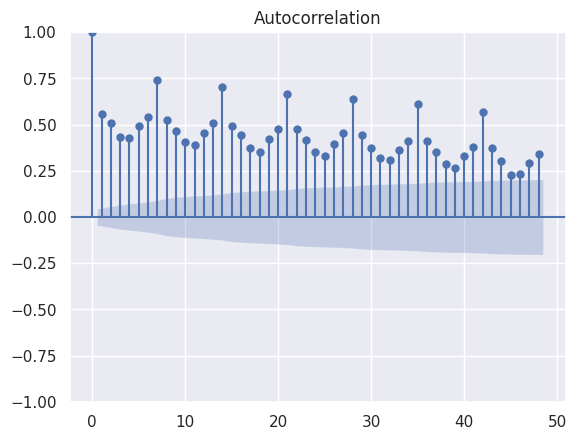

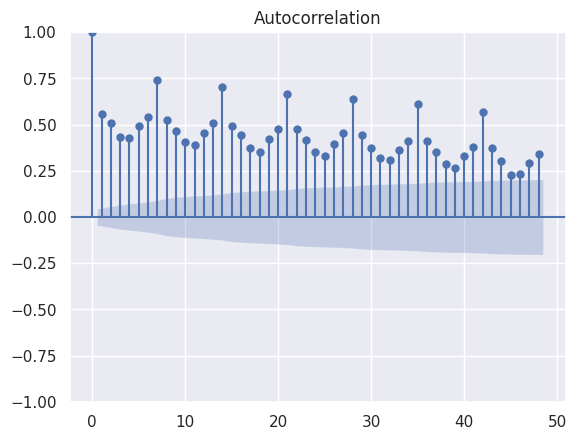

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(time_series, lags=48)

ACF --> ไม่มีค่าที่โดดเด่น แทบจะคล้ายๆกันหมด MA จะไม่เหมาะ , ใช้หา q  SARIMAX

q SARIMAX อาจจะเป็น 1 ค่อนข้างชัดเจน จะเห็นแพทเทิร์นเป็น seasonality วนลูปทุกวีค

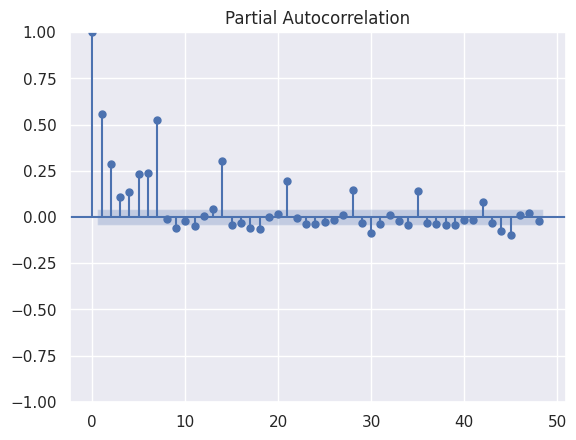

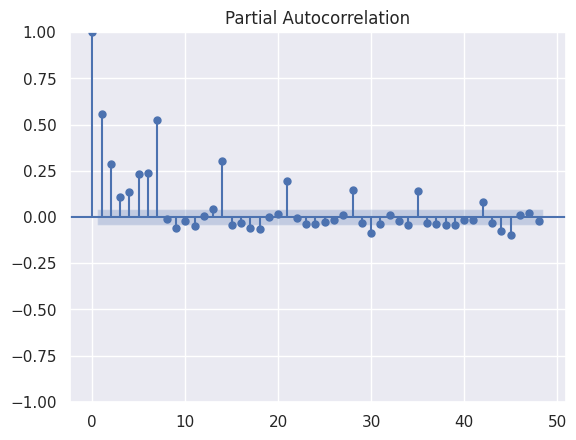

In [49]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(time_series, lags=48)

PACF --> AR model, p SARIMAX

p SARIMAX อาจจะเป็น 2/3 แต่ 3 เหมือนเริ่มเข้าสู่ conf interval

In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

# Perform the Ljung-Box test -- White Noise Test
ljung_test = acorr_ljungbox(time_series, lags=[10], return_df=True)

print(ljung_test)     # White Noise if p-value > 0.05

      lb_stat  lb_pvalue
10 6792413.19       0.00


The Time Series data is not white noise, meaning it has some underlying pattern.
Since the data is not purely random, we can apply forecasting models to predict future values.

➤ เรามีข้อมูลแบบนี้ :
- ข้อมูลยอดขายทุกวัน

- สำหรับแต่ละสาขาและสินค้า

- มี underlying patterns เช่น

ยอดขายโตเพราะเศรษฐกิจดี (Trend)

คนซื้อเยอะทุกสิ้นเดือน (Seasonality)

มีจู่ ๆ ยอดขายตก เพราะ stock-out (Noise)

### 5. Seasonal Decomposition  --> ARIMA/SARIMA

ถ้าไม่ทำ Decomposition → โมเดลอาจมองไม่เห็น pattern ที่สำคัญ

In [29]:
random_stores = np.random.choice(train_df['store'].unique(), size=2, replace=False)
random_items = np.random.choice(train_df['item'].unique(), size=2, replace=False)

### period = 7

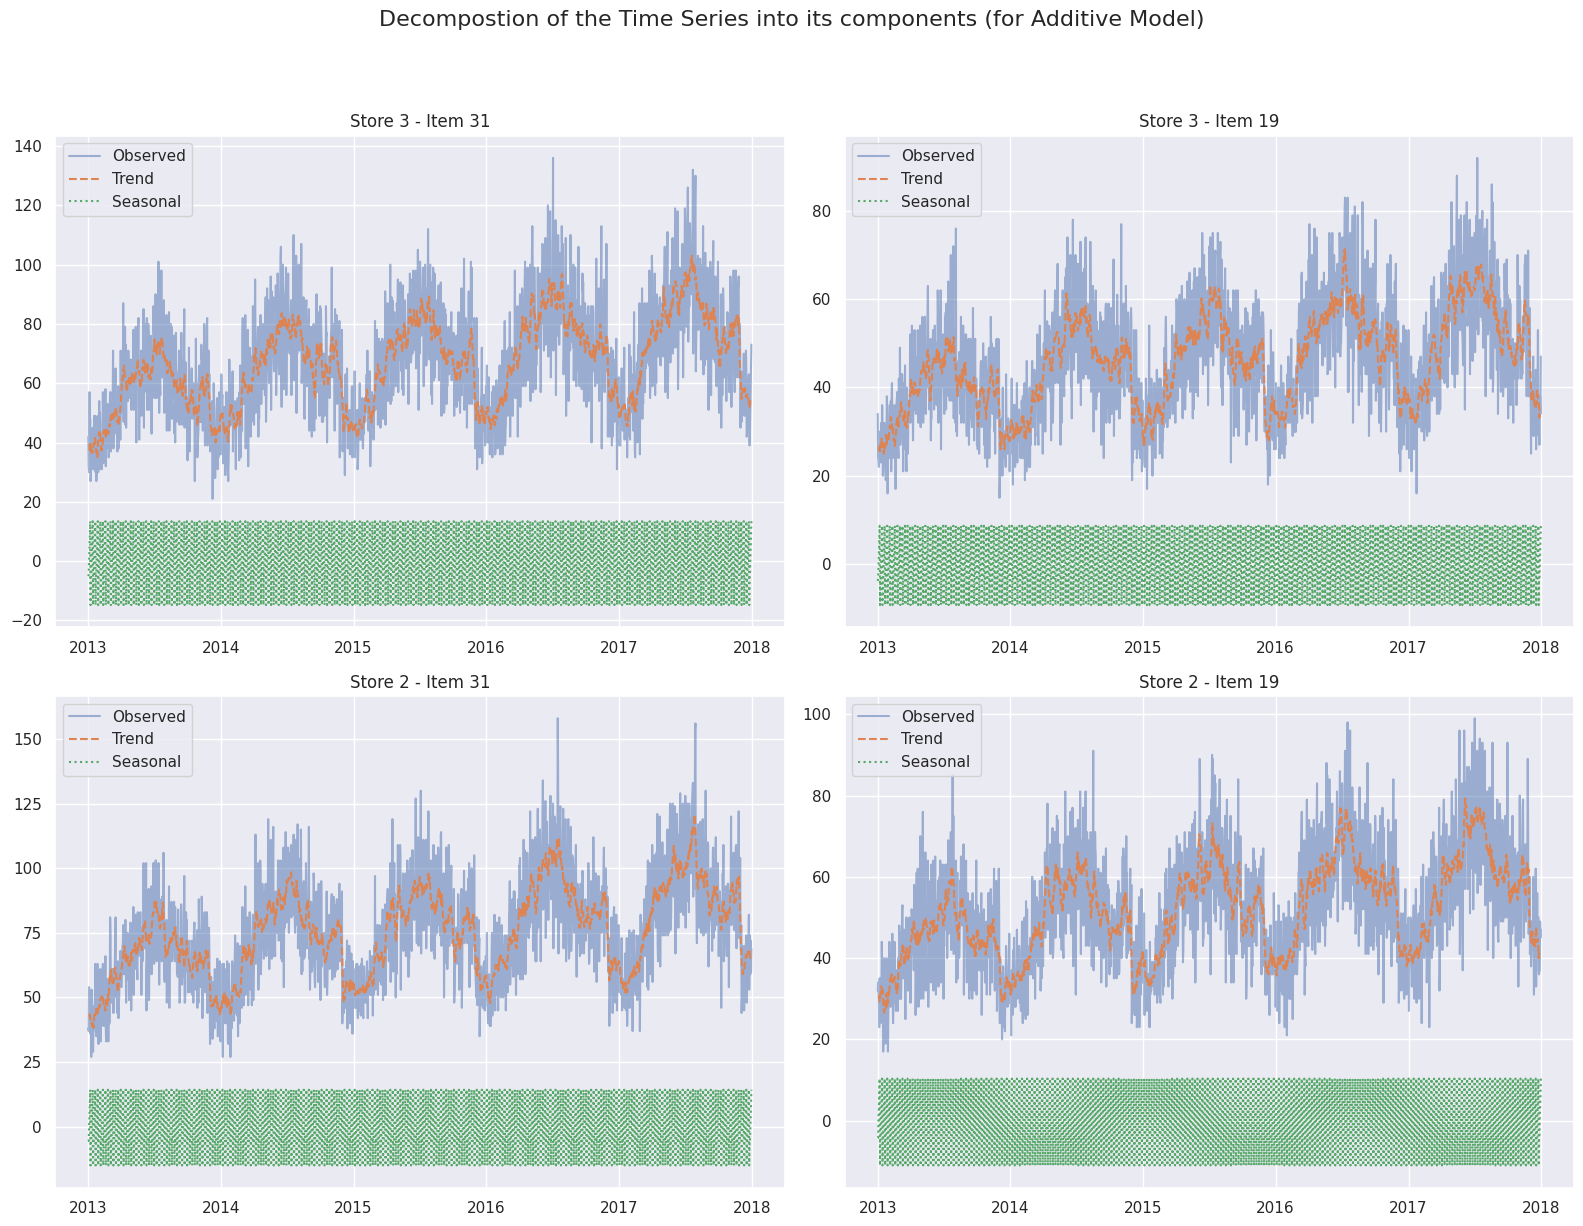

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

# time_series = train_df[(train_df['store'] == 7) & (train_df['item'] == 1)].set_index('date')['sales'].asfreq('D')

# plt.figure(figsize=(12,10))
# decomposition_add = seasonal_decompose(time_series, model = 'additive', period = 7)
# decomposition_add.plot()

# plt.title('Decompostion of the Time Series into its components (for Additive Model)\n',pad = 250, position = (0.5,0.2))
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

plot_idx = 0

for store_id in random_stores:
    for item_id in random_items:
        time_series = train_df[
            (train_df['store'] == store_id) & (train_df['item'] == item_id)
        ].set_index('date')['sales'].asfreq('D')

        # TODO: must have no missing values and sufficient for 7 days
        if time_series.isna().sum() == 0 and len(time_series) >= 30:
            decomposition = seasonal_decompose(time_series, model='additive', period=7)
    
            axs[plot_idx].plot(decomposition.observed, label='Observed', alpha=0.5)
            axs[plot_idx].plot(decomposition.trend, label='Trend', linestyle='--')
            axs[plot_idx].plot(decomposition.seasonal, label='Seasonal', linestyle=':')
            axs[plot_idx].set_title(f"Store {store_id} - Item {item_id}")
            axs[plot_idx].legend()
            plot_idx += 1

plt.suptitle(f'Decompostion of the Time Series into its components (for Additive Model)\n', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()       

📊 วิเคราะห์ผลจากกราฟ decomposition
1. Observed (daily sales) : มีลักษณะขึ้นลงแบบมีลูป ค่าต่างๆ แกว่งพอประมาณ มีความเป็น pattern
2. Trend : pattern ขึ้นลงเหมือนกันทุกปี  ดูเหมือนจะมีบางช่วงที่ยอดขายสูงขึ้นต่อเนื่อง (น่าจะมี seasonal demand boost หรือ promotion)
3. Seasonal :  Seasonal flat (แทบไม่มี pattern รายสัปดาห์)  ค่าแกว่งน้อย คงที่มาก

### period 30 days

- Addictive = Y(t) = Trend(t) + Seasonal(t) + Residual(t) 

- Multiplicative = Y(t) = Trend(t) × Seasonal(t) × Residual(t)

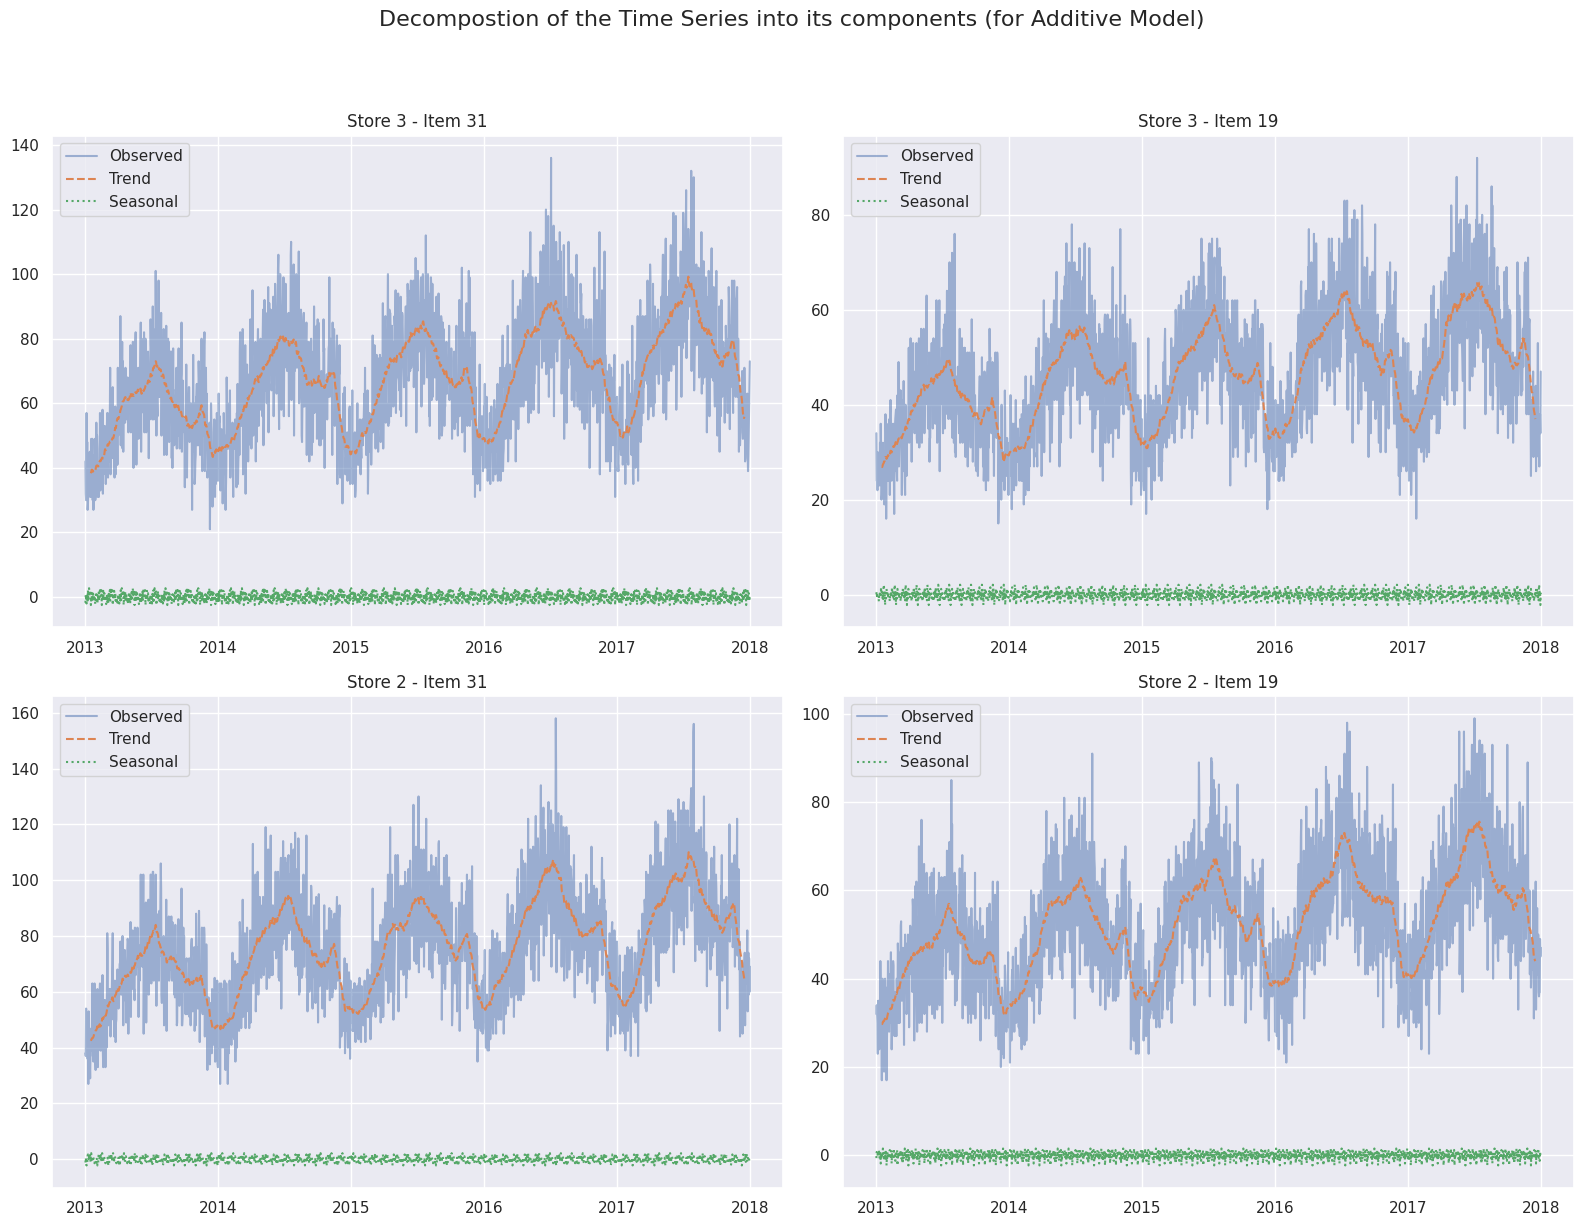

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

plot_idx = 0

for store_id in random_stores:
    for item_id in random_items:
        time_series = train_df[
            (train_df['store'] == store_id) & (train_df['item'] == item_id)
        ].set_index('date')['sales'].asfreq('D')

        # TODO: must have no missing values and sufficient for 30 days
        if time_series.isna().sum() == 0 and len(time_series) >= 90:
            decomposition = seasonal_decompose(time_series, model='additive', period=30) # multiplicative should be used if seasonal variant with trends
    
            axs[plot_idx].plot(decomposition.observed, label='Observed', alpha=0.5)
            axs[plot_idx].plot(decomposition.trend, label='Trend', linestyle='--')
            axs[plot_idx].plot(decomposition.seasonal, label='Seasonal', linestyle=':')
            axs[plot_idx].set_title(f"Store {store_id} - Item {item_id}")
            axs[plot_idx].legend()
            plot_idx += 1

plt.suptitle(f'Decompostion of the Time Series into its components (for Additive Model)\n', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()       

1. Observed (daily sales) : มีลักษณะขึ้นลงแบบมีลูป ค่าต่างๆ แกว่งพอประมาณ มีความเป็น pattern
2. Trend : pattern ขึ้นลงเหมือนกันทุกปี  strong smooth มาก
3. Seasonal :  Seasonal flat (แทบไม่มี pattern รายสัปดาห์)  ค่าแกว่งน้อย คงที่มาก

### period 365 days

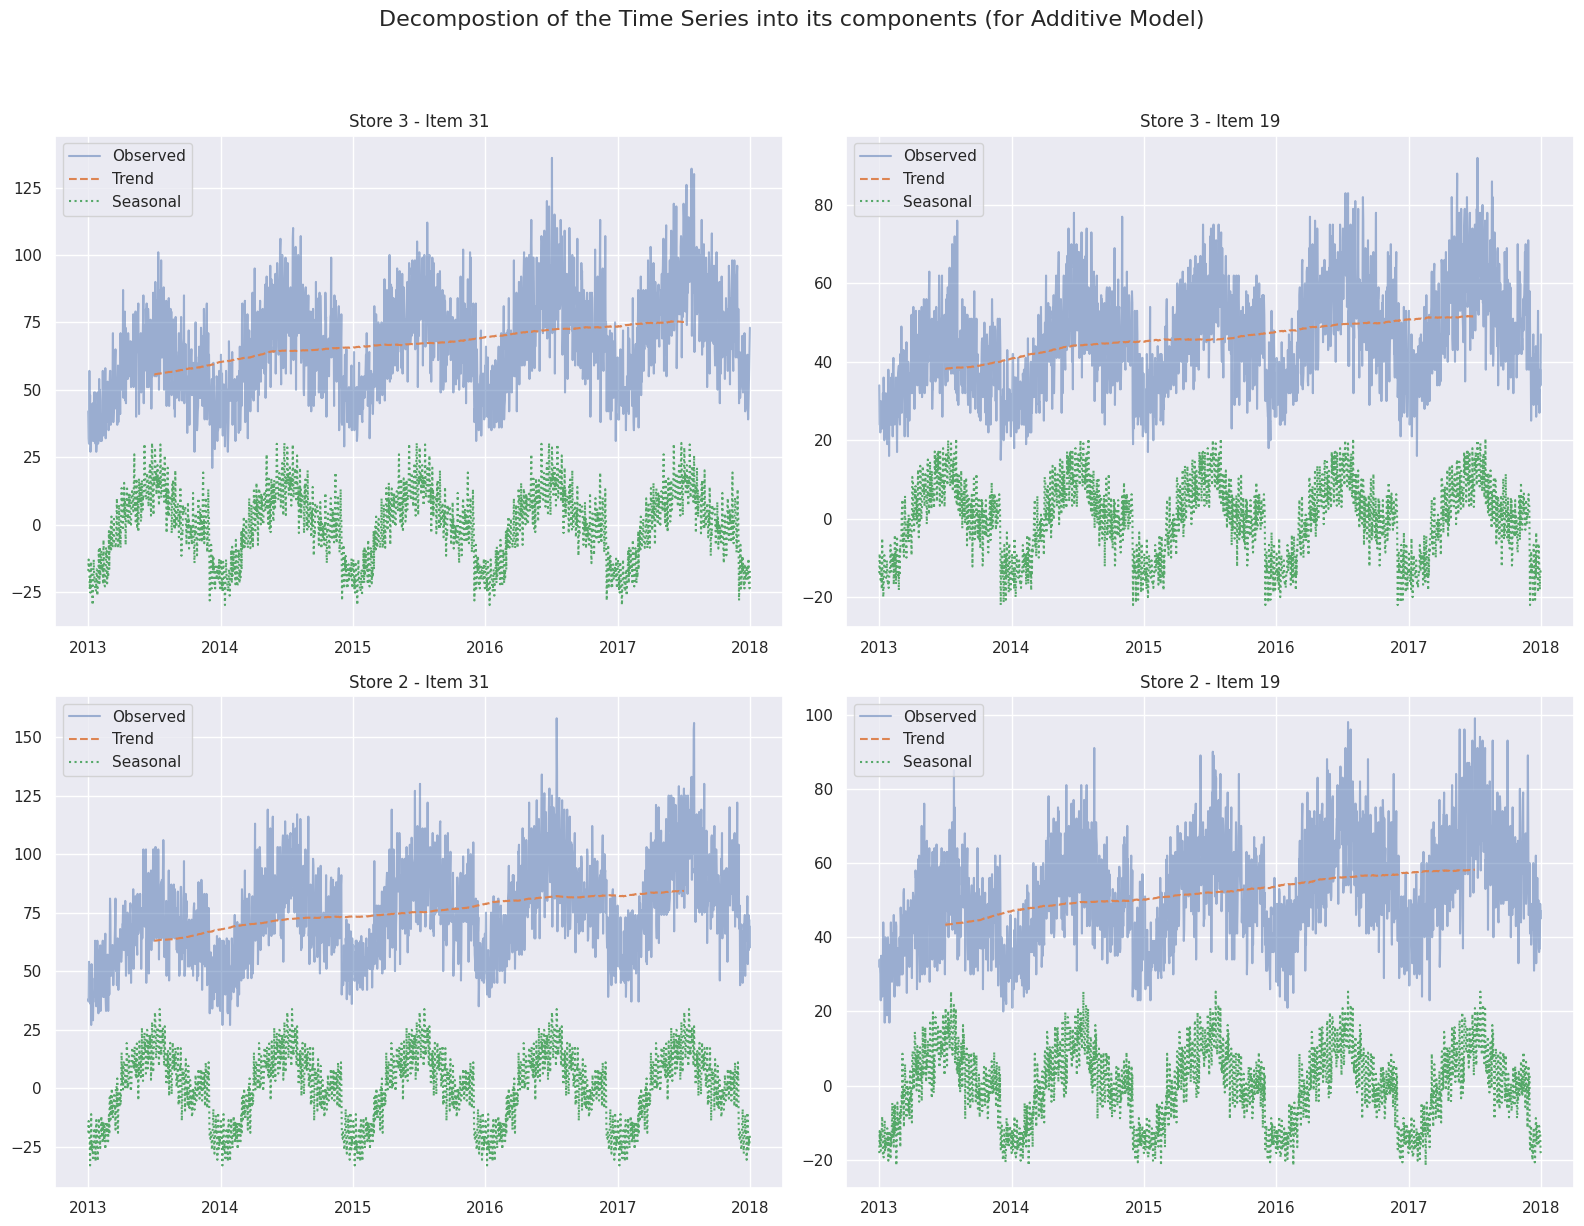

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

plot_idx = 0

for store_id in random_stores:
    for item_id in random_items:
        time_series = train_df[
            (train_df['store'] == store_id) & (train_df['item'] == item_id)
        ].set_index('date')['sales'].asfreq('D')

        # TODO: must have no missing values and sufficient for 365 days
        if time_series.isna().sum() == 0 and len(time_series) >= 1000:
            decomposition = seasonal_decompose(time_series, model='additive', period=365)
    
            axs[plot_idx].plot(decomposition.observed, label='Observed', alpha=0.5)
            axs[plot_idx].plot(decomposition.trend, label='Trend', linestyle='--')
            axs[plot_idx].plot(decomposition.seasonal, label='Seasonal', linestyle=':')
            axs[plot_idx].set_title(f"Store {store_id} - Item {item_id}")
            axs[plot_idx].legend()
            plot_idx += 1

plt.suptitle(f'Decompostion of the Time Series into its components (for Additive Model)\n', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()       

The seasonal pattern becomes very clear. Seasonal amplitude is consistent → additive model is valid
Trend slowly increasing but quite flat.

### 6. Stationery Test

Check before we use ARIMA/SARIMA
ARIMA/SARIMA ต้องใช้กับข้อมูลที่ "stationary" เท่านั้น
ถ้าไม่ stationary → ต้อง "ทำให้มัน stationary" ด้วย Differencing

We can use SARIMA (p,d,q)(P,D,Q,365) or Fourier features for yearly cycles.

### ADF Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_results = adfuller(time_series)
print('ADF Statistic = ', adf_results[0])   
print('p-value = ', adf_results[1])   # Stationary if p-value < 0.5

ADF Statistic =  -2.8721522054983004
p-value =  0.048683474574204716


ถ้า ADF p-value < 0.05 → stationary → ไม่ต้อง diff เพิ่ม

### KPSS Test

In [41]:
from statsmodels.tsa.stattools import kpss

statistic, p_value, n_lags, critical_values = kpss(time_series, regression='ct')

print('KPSS Statistic:', statistic)
print('p-value:', p_value)   # Stationary if p-value >= 0.05

KPSS Statistic: 0.07680124648583361
p-value: 0.1


/tmp/ipykernel_3445382/3577445187.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(time_series, regression='ct')


The time series data is stationary and so perfect!

### 7. Find fitting trend line over Tme Series data by using OLS Regression

“ยอดขายโดยรวมของสินค้านี้ เพิ่มขึ้นหรือลดลงเมื่อเวลาผ่านไป?” --> คำตอบ: fitting linear แล้วดูค่า slope

In [42]:
time_index = np.arange(0, len(time_series)) # สร้างตัวแปรเวลา (0, 1, 2, ..., N) เพื่อเป็น feature ในการฟิตเส้น
time_index_add_constant = sm.add_constant(time_index)  # ใส่ constant สำหรับ intercept
trend_line = sm.OLS(time_series, time_index_add_constant).fit() # ใช้ Ordinary Least Squares Regression เพื่อหาเส้นตรงที่ best-fit กับยอดขาย
print(trend_line.summary())


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     298.9
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           3.97e-62
Time:                        00:37:32   Log-Likelihood:                -7326.4
No. Observations:                1826   AIC:                         1.466e+04
Df Residuals:                    1824   BIC:                         1.467e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.4481      0.626     67.802      0.0


- x1 (slope)= 0.0103	 ค่าเฉลี่ยยอดขายเพิ่มขึ้น 0.0103 หน่วยต่อวัน
- P>|t| = 0.000  บอกว่า slope นี้ น่าจะไม่ใช่แค่ random noise → มีแนวโน้มจริง
- R-squared	0.141	 14.1% ค่าต่ำ แปลว่าเวลาอธิบายยอดขายได้แค่บางส่วน ยังมี seasonal หรือ noise ที่ส่งผลมากกว่า
- Durbin-Watson	1.031 มี autocorrelation ของ residual (เป็นธรรมชาติของ time series)  ถ้า ค่าใกล้ 2 = residual ไม่ autocorrelated  ถ้าใกล้ 1 → มี autocorrelation → เป็นสัญญาณว่าใช้ AR/SARIMA ดีกว่า OLS ล้วน ๆ


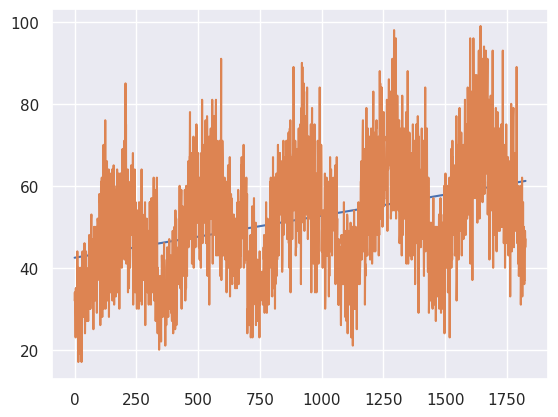

In [43]:
plt.plot(time_index, trend_line.predict(time_index_add_constant))  # trend line
plt.plot(time_index, time_series) 

As you can see from the graph,  trend line ชันขึ้นเล็กน้อย → slope > 0, ยอดขายของ series นี้ มีแนวโน้มเพิ่มขึ้นอย่างช้า ๆ , แต่ amplitude (การแกว่งขึ้นลงของยอดขาย) ไม่ได้แปรตาม trend → seasonality แบบ additive



### Optimized: Noise and outliers handling

Post-error analysis

In [ ]:
def prepare_ts(train_df, store, item, forecast_horizon=30, rolling_window=7):
    # Filter data for the current store-item pair
    ts_df = train_df[(train_df['store'] == store) & (train_df['item'] == item)].copy()
    
    # Set datetime index
    ts_df = ts_df[['date', 'sales']].set_index('date').sort_index()
    ts_df = ts_df.asfreq('D')  # Ensure consistent daily frequency
    ts_df['sales'] = ts_df['sales'].astype(float)
    ts_df['sales'] = ts_df['sales'].bfill().ffill()
    # Denoise using rolling mean (smoothing)
    ts_df['sales_smooth'] = ts_df['sales'].rolling(window=7, center=True).mean()


    # Handle outliers using z-score
    from scipy.stats import zscore
    ts_df['z_score'] = zscore(ts_df['sales'].fillna(0))
    ts_df['outlier'] = ts_df['z_score'].abs() > 3
    
    # cap outliers
    capped_sales = ts_df['sales'].copy()
    outliers = ts_df['outlier']
    capped_sales.loc[outliers] = ts_df.loc[outliers, 'sales_smooth']
    ts_df['sales_clean'] = capped_sales

    # Choose which to use for modeling
    # You can return smoothed, clean, or original
    time_series = ts_df['sales_clean']

    # Split train/test
    train_series = time_series[:-forecast_horizon]
    eval_series = time_series[-forecast_horizon:]

    return train_series, eval_series, ts_df  



### 8. Modelling

# Univariate Time Series

Cons of ARIMA & SARIMA

Amount of data needed: Both the algorithms require considerable data to work on, especially if the data is seasonal. For example, using three years of historical demand is likely not to be enough (Short Life-Cycle Products) for a good forecast.
- Ref: https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide

AR (Autoregressive) and similar classical models (ARIMA, SARIMA, etc.) are univariate and assume stationarity + structure within a single time series. So you can't batch all stores, items because you're mixing signals (trends, seasonality, noise) from different products, which is statistically invalid for AR model.

### AR Model

lag 20

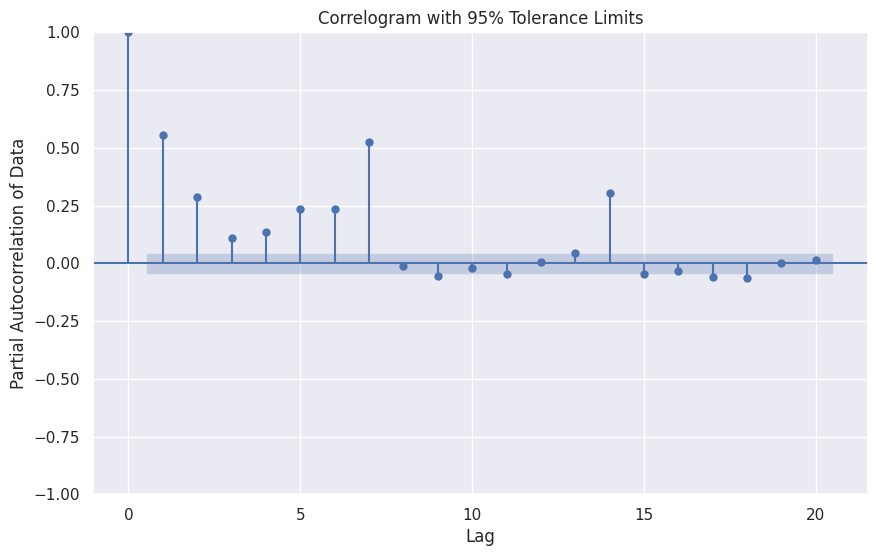

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_pacf(time_series, lags=20, alpha=0.05, ax=ax)

plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation of Data')
plt.title('Correlogram with 95% Tolerance Limits')
plt.show()

Lag 1 มี autocorrelation สูงมาก (≈ 1.0)  Lag 2–3 ยัง significant ลดลงมา หลังจากนั้นเริ่มลด → บ่งบอกว่าอาจใช้ AR(2) หรือ AR(3)
- lag 7+ is in the 95% confidence interval so pls don't use coz it's a noise
- ใช้สำหรับเลือก p ใน AR(p)
- ถ้า spike ใด ทะลุแถบฟ้าออกมา → แสดงว่ามี partial autocorrelation ที่เด่นชัด
- อาจเริ่มลอง ARIMA(2,d,q) หรือ SARIMA(2,d,q)(P,D,Q,s)

lag 48

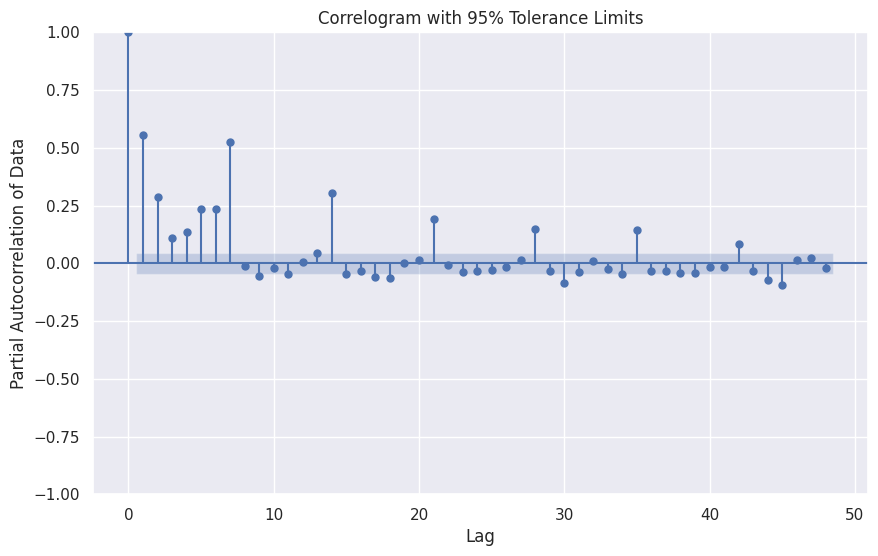

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_pacf(time_series, lags=48, alpha=0.05, ax=ax)

plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation of Data')
plt.title('Correlogram with 95% Tolerance Limits')
plt.show()

มีจุด spike ที่ lag 7, 14, 21, 28 (ประมาณ)  เป็นสัญญาณของ weekly seasonality
เช่น: Lag 7 = 1 สัปดาห์, Lag 14 = 2 สัปดาห์ 

-บ่งบอกว่าโมเดลควรใช้ seasonality
→ SARIMA with seasonal_order=(P,D,Q,7)

*confidence interval หลุดนอกกรอบ คือ  significant lag

ส่วนใหญ่หลัง  lag 10 เริ่มนิ่ง

why p = 2? The last significant PACF spike is at lag 2.

In [59]:
!pwd

/home/nsamaira


In [62]:
!cd /home/nsamaira/framee17/demand-forecasting/data

In [10]:
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

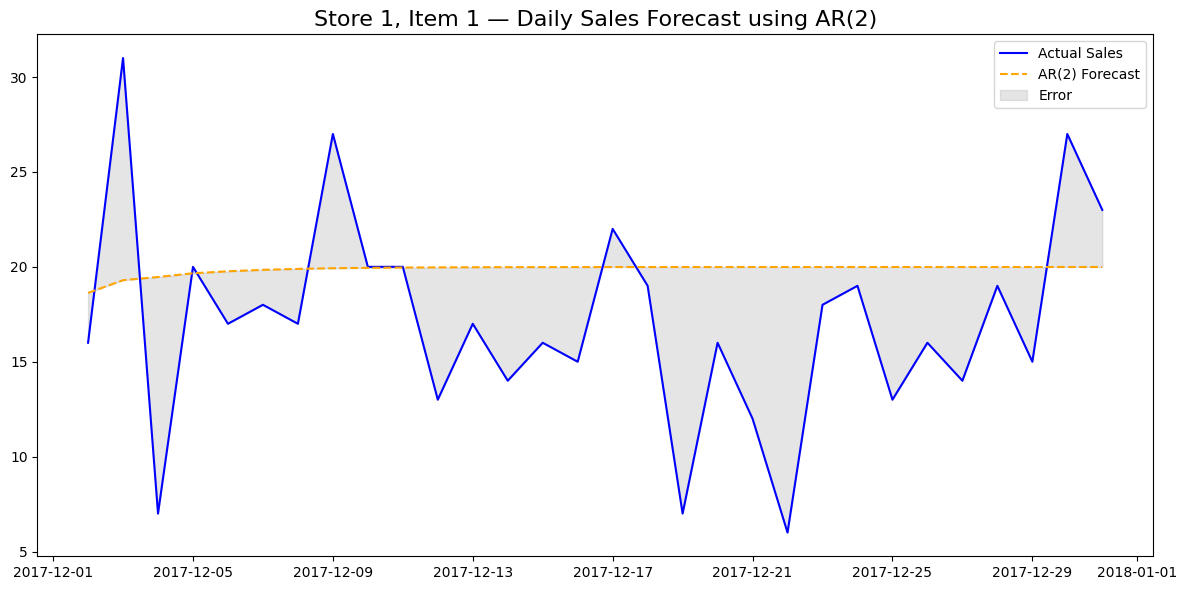

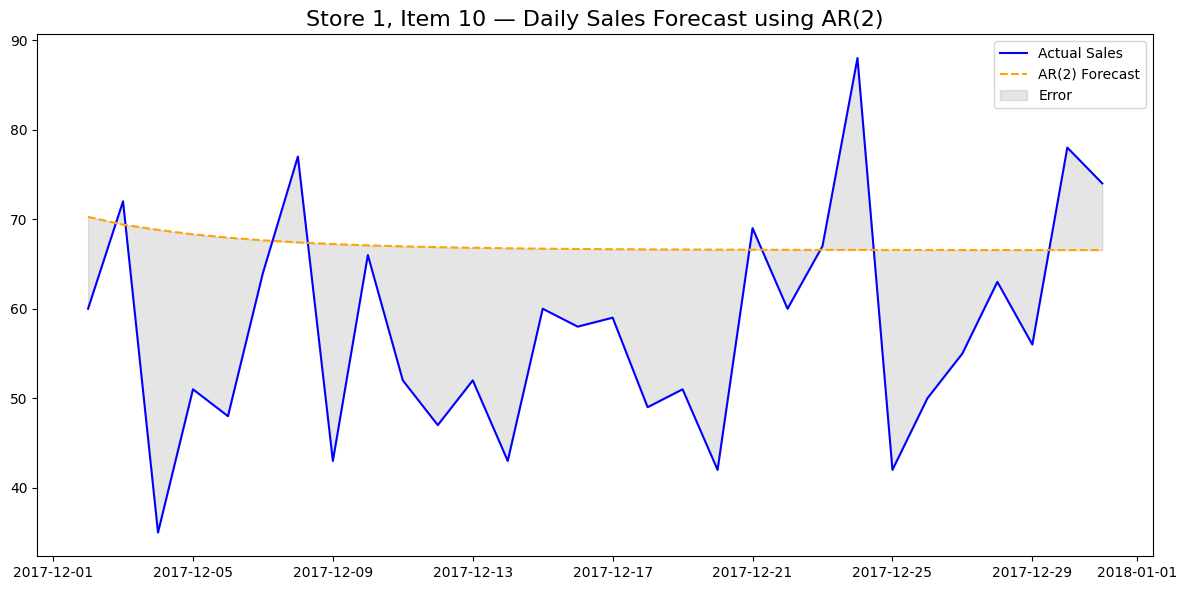

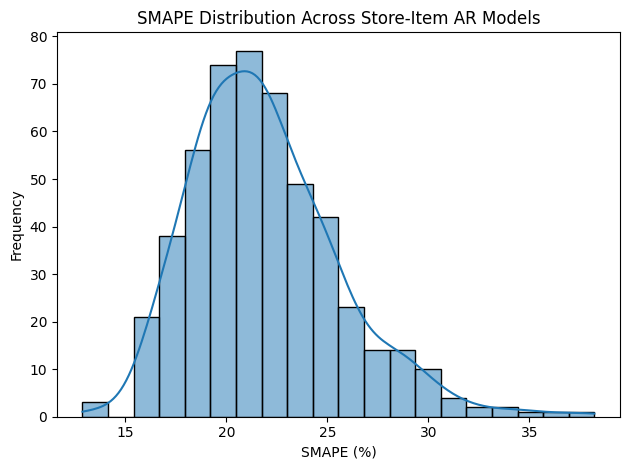

store  item  rmse   mae  smape
94       2    45 16.03 11.85  12.87
32       1    33 10.47  7.78  14.08
160      4    11 12.15  9.38  14.09
410      9    11 13.13 10.46  15.68
380      8    31 12.69 10.04  15.75
387      8    38 17.59 14.05  15.75
124      3    25 16.56 12.99  15.97
132      3    33 14.05 11.29  16.04
463     10    14 11.55  9.58  16.11
104      3     5  4.12  3.09  16.15

In [29]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Config
forecast_horizon = 30  # days to predict
lag_order = 2        # AR(p), from PACF
results = []           # to store evaluation metrics
plot_examples = True   # turn on/off visual plots

# Iterate over all (store, item) pairs
store_ids = train_df['store'].unique()
item_ids = train_df['item'].unique()

for store in store_ids:
    for item in item_ids:
        train_data, eval_data, ts_meta = prepare_ts(train_df, store, item, forecast_horizon=forecast_horizon)
        if len(train_data) < lag_order + forecast_horizon:
            continue

        # Fit AR(p) model
        model = AutoReg(train_data, lags=lag_order)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train_data),
                                        end=len(train_data) + len(eval_data) - 1,
                                        dynamic=False)

        # Eval
        rmse = round(root_mean_squared_error(eval_data, predictions), 2)
        smape_score = round(smape(eval_data, predictions), 2)
        mae = round(mean_absolute_error(eval_data, predictions), 2)

        results.append({
            'store': store,
            'item': item,
            'rmse': rmse,
            'mae': mae,
            'smape': smape_score
        })

        # Visualize eval results
        if plot_examples and store == 1 and item in [1, 10]:
            plt.figure(figsize=(12, 6))
            plt.plot(eval_data.index, eval_data, label='Actual Sales', color='blue')
            plt.plot(eval_data.index, predictions, label=f'AR({lag_order}) Forecast', color='orange', linestyle='--')
            plt.fill_between(eval_data.index, eval_data, predictions, color='gray', alpha=0.2, label='Error')
            plt.title(f'Store {store}, Item {item} — Daily Sales Forecast using AR({lag_order})', fontsize=16)
            plt.legend()
            plt.tight_layout()
            plt.show()

results_df = pd.DataFrame(results)
# results_df = results_df.sort_values('smape') #sort by smape

sns.histplot(results_df['smape'], bins=20, kde=True)
plt.title('SMAPE Distribution Across Store-Item AR Models')
plt.xlabel('SMAPE (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

results_df.to_csv('ar2_model_results.csv', index=False)
results_df.sort_values("smape").head(10)

In [30]:
avg_rmse = results_df["rmse"].mean()
avg_mae = results_df["mae"].mean()
avg_smape = results_df["smape"].mean()
print("average rmse", avg_rmse)
print("average mae", avg_mae)
print("average smape", avg_smape)

average rmse 11.4762
average mae 9.535560000000002
average smape 21.913059999999998


In [31]:
test_df

id       date  store  item
0          0 2018-01-01      1     1
1          1 2018-01-02      1     1
2          2 2018-01-03      1     1
3          3 2018-01-04      1     1
4          4 2018-01-05      1     1
...      ...        ...    ...   ...
44995  44995 2018-03-27     10    50
44996  44996 2018-03-28     10    50
44997  44997 2018-03-29     10    50
44998  44998 2018-03-30     10    50
44999  44999 2018-03-31     10    50

[45000 rows x 4 columns]

In [18]:
test_df['store'].unique()
test_df['item'].unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

### sample test AR(2)

Test dates: ['2018-01-01T00:00:00.000000000' '2018-01-02T00:00:00.000000000'
 '2018-01-03T00:00:00.000000000'] ... total: 90
Forecast sample: 2017-12-02   18.63
2017-12-03   19.30
2017-12-04   19.46
Freq: D, dtype: float64


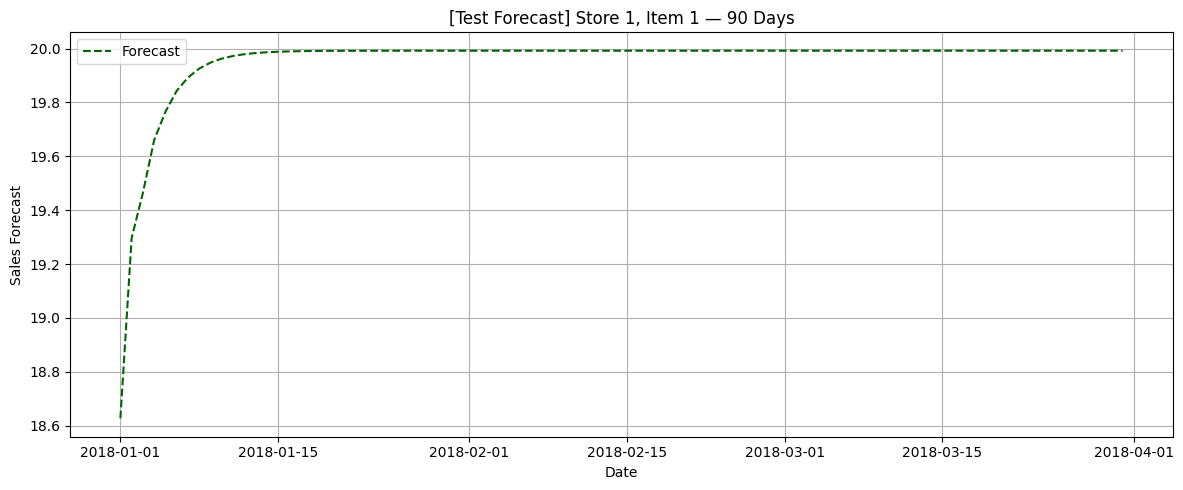

In [32]:
store, item = 1, 1  
train_data, eval_data, _ = prepare_ts(train_df, store, item, forecast_horizon=30)

# Fit AR model
model = AutoReg(train_data, lags=2)
model_fit = model.fit()

# heck test data
test_data = test_df[(test_df['store'] == store) & (test_df['item'] == item)].copy()
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values('date')
test_dates = test_data['date'].values
forecast_horizon = len(test_dates)

print("Test dates:", test_dates[:3], "... total:", forecast_horizon)
test_forecast = model_fit.forecast(steps=forecast_horizon)
print("Forecast sample:", test_forecast[:3])

plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_forecast, label="Forecast", color="darkgreen", linestyle="--")
plt.title(f'[Test Forecast] Store {store}, Item {item} — {forecast_horizon} Days')
plt.xlabel("Date")
plt.ylabel("Sales Forecast")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### SMAPE Distribution
ค่าเฉลี่ย SMAPE	ค่าที่ mode อยู่ประมาณ ~21–22% ถือว่าดีสำหรับ baseline ที่เป็น AR(2) บน daily sales (ข้อมูล noisy)
ความเบ้ (Skew) 	Distribution เบี้ยวขวา (right-skewed) → แปลว่ามีหลายคู่ store-item ที่ SMAPE สูงกว่าค่าเฉลี่ยมาก (โมเดลทำงานไม่ดี)


- เส้น Forecast (เส้นประสีส้ม) ค่อนข้าง "แบน" หรือคงที่มาก (สังเกตว่าไม่สามารถจับ spike หรือ dip ได้ดี) → นี่เป็นธรรมชาติของ AR model (โดยเฉพาะ order ต่ำอย่าง AR(2)) ที่จะไม่สามารถเข้าใจ pattern ซับซ้อนหรือ seasonality ได้ดี
- พื้นที่สีเทา (Forecast Error) ในบางช่วงมีช่วงกว้างมาก → โมเดลอาจยัง underfit หรือไม่มีพลังพอในการอธิบายความแปรปรวนในข้อมูลได้


**ลองปรับ AR(3) AR(7) ลด training data ก็ไม่ทำให้ผลลัพธ์ดีขึ้น 

**ACF, Decomposition ค่อนข้างมีแพทเทิร์น seasonal ชัด**  ทำให้การใช้ AR กับ ARIMA ไม่ได้ประสิทธิภาพสูงสุด

## SARIMA
- p= AR (AutoRegressive) term – lags of the time series (from PACF)
- d = Order of differencing to make the series stationary (ADF/KPSS)
- q= MA (Moving Average) term – lag of the forecast errors (from ACF)
- P, D, Q, s	Seasonal counterparts (for weekly, set s = 7)

now, d = 0 (stationary), s=7 (weekly), q=1 (ACF), p=2 (PACF)

### Find P, Q

In [8]:
print(time_series.diff(7).dropna().head(10))


7    -4.00
8     1.00
9    -5.00
10   -4.00
11   -3.00
12   -2.00
13    2.00
14   -4.00
15   -5.00
16    7.00
Name: sales, dtype: float64


In [9]:
print("Original length:", len(time_series))
print("After seasonal diff:", len(time_series.diff(7).dropna()))

Original length: 913000
After seasonal diff: 912993


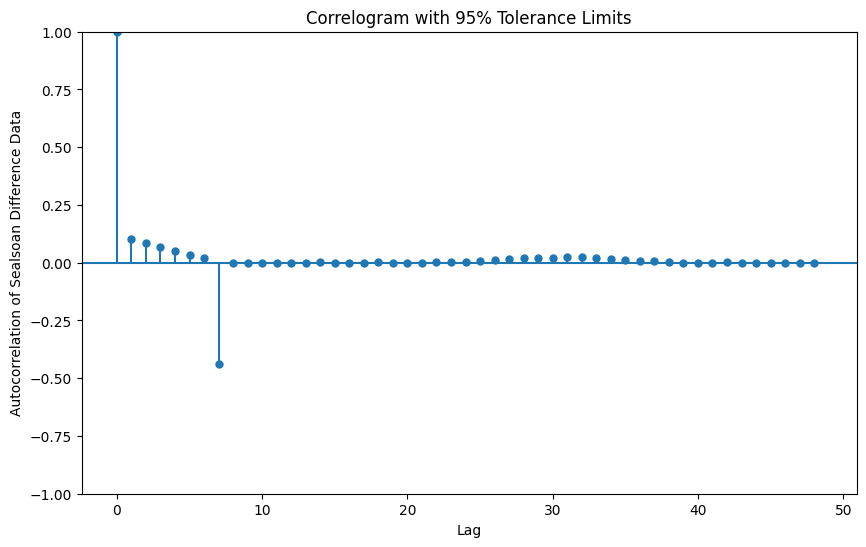

In [12]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_acf(time_series.diff(7).dropna(), lags=48, alpha=0.05, ax=ax) #weekly

plt.xlabel('Lag')
plt.ylabel('Autocorrelation of Sealsoan Difference Data')
plt.title('Correlogram with 95% Tolerance Limits')
plt.show()

Q = 1

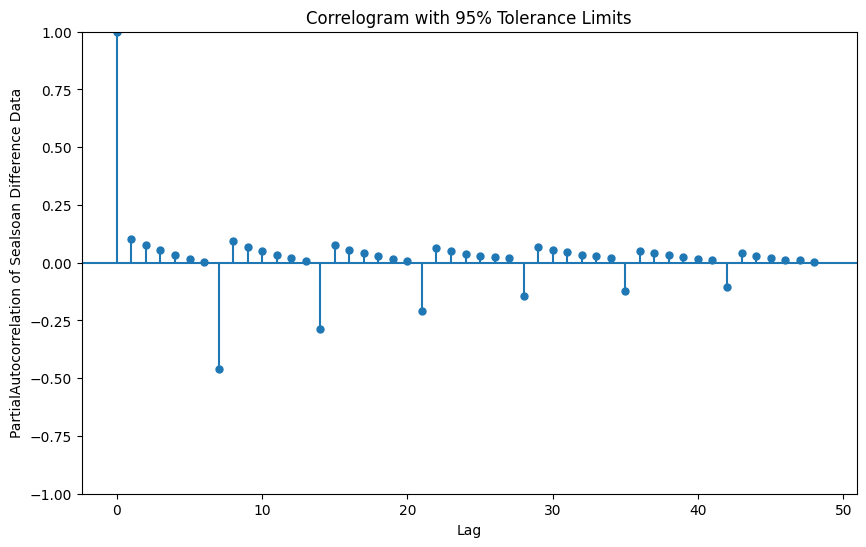

In [14]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_pacf(time_series.diff(7).dropna(), lags=48, alpha=0.05, ax=ax) #weekly

plt.xlabel('Lag')
plt.ylabel('PartialAutocorrelation of Sealsoan Difference Data')
plt.title('Correlogram with 95% Tolerance Limits')
plt.show()

P=1

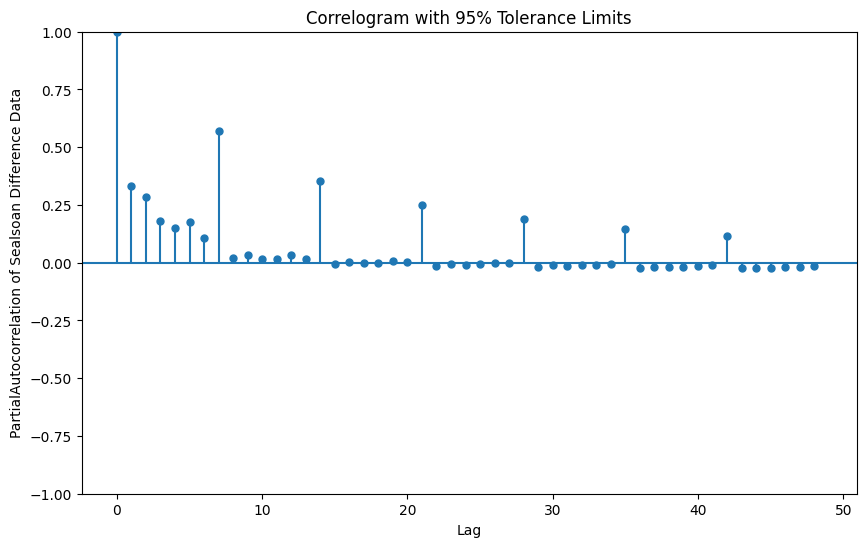

In [16]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_pacf(time_series.diff(365).dropna(), lags=48, alpha=0.05, ax=ax) #weekly

plt.xlabel('Lag')
plt.ylabel('PartialAutocorrelation of Sealsoan Difference Data')
plt.title('Correlogram with 95% Tolerance Limits')
plt.show()

### now, d = 0 (stationary), s=7 (weekly), q=1 (ACF), p=2 (PACF) --> P=1, Q=1

### Find D=?

- If ACF of the seasonally differenced series (.diff(s)) drops off quickly, → D=1 is likely enough.
If not → consider D=2.

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss

# Seasonal differencing
seasonal_diff = time_series.diff(7).dropna()

# ADF test
print("ADF p-value (seasonal diff):", adfuller(seasonal_diff)[1])  # < 0.05 → stationary

# KPSS test
statistic, p_value, _, _ = kpss(seasonal_diff, regression='c', nlags="auto")
print("KPSS p-value (seasonal diff):", p_value)  # > 0.05 → stationary


ADF p-value (seasonal diff): 0.0
KPSS p-value (seasonal diff): 0.1


/tmp/ipykernel_3904136/3539880767.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, _, _ = kpss(seasonal_diff, regression='c', nlags="auto")


D = 1

In [7]:
from joblib import Parallel, delayed
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter("ignore", UserWarning)
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

def train_sarima_model(store, item, df, forecast_horizon=30, order=(2, 0, 1), seasonal_order=(1, 1, 1, 7), plot_example=True):
    print(f"Start → Store {store}, Item {item}")

    ts_df = df[(df['store'] == store) & (df['item'] == item)].copy()
    ts_df = ts_df[['date', 'sales']].set_index('date').sort_index()
    ts_df = ts_df.asfreq('D')

    if len(ts_df) < 60:
        print(f"⏭ SKIPPED: Store {store}, Item {item} — Not enough data ({len(ts_df)} rows)")
        return None

    try:
        time_series = ts_df['sales']
        train_data = time_series[:-forecast_horizon]
        eval_data = time_series[-forecast_horizon:]

        model = SARIMAX(
            train_data,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=True,
            enforce_invertibility=True
        )
        model_fit = model.fit(disp=False, maxiter=1000)
        # print(f"FIT OK: Store {store}, Item {item}")

        predictions = model_fit.predict(
            start=len(train_data),
            end=len(train_data) + len(eval_data) - 1,
            dynamic=False
        )

        rmse = np.sqrt(mean_squared_error(eval_data, predictions))
        smape_score = smape(eval_data, predictions)

        if plot_example and store == 1 and item in [1, 10]:
            plt.figure(figsize=(12, 6))
            plt.plot(eval_data.index, eval_data, label='Actual Sales', color='blue')
            plt.plot(eval_data.index, predictions, label='SARIMA Forecast', color='orange', linestyle='--')
            plt.fill_between(eval_data.index, eval_data, predictions, color='gray', alpha=0.2, label='Error')
            plt.title(f'Store {store}, Item {item} — Daily Sales Forecast using SARIMA', fontsize=16)
            plt.legend()
            plt.grid(True)
            plt.show()

        print(f"Result: Store {store}, Item {item} | RMSE: {rmse:.2f}, SMAPE: {smape_score:.2f}%")
        return {
            'store': store,
            'item': item,
            'rmse': round(rmse, 2),
            'smape': round(smape_score, 2)
        }

    except Exception as e:
        print(f"FAIL: Store {store}, Item {item} — {str(e)}")
        return None

# Run Parallel
n_jobs = -1
store_ids = train_df['store'].unique()
item_ids = train_df['item'].unique()
store_item_pairs = [(s, i) for s in store_ids for i in item_ids]

print(f"Total Combinations: {len(store_item_pairs)}")

results = Parallel(n_jobs=n_jobs)(
    delayed(train_sarima_model)(store, item, train_df, order=(2, 0, 1), seasonal_order=(1, 1, 1, 7), plot_example=True)
    for store, item in store_item_pairs
)


results = [r for r in results if r is not None]
sarima_results_df = pd.DataFrame(results)

print(f"\nFINISHED: {len(sarima_results_df)} successful models")


Total Combinations: 500


/home/nsamaira/miniconda3/envs/framee17/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/nsamaira/miniconda3/envs/framee17/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/nsamaira/miniconda3/envs/framee17/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/nsamaira/miniconda3/envs/framee17/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive param


FINISHED: 500 successful models


In [8]:
print(len(sarima_results_df))

500


In [9]:
sarima_results_df

store  item  rmse  smape
0        1     1  6.66  32.36
1        1     2 19.04  32.77
2        1     3  9.81  28.38
3        1     4  8.02  39.42
4        1     5  6.49  36.54
..     ...   ...   ...    ...
495     10    46 21.83  32.03
496     10    47 10.91  41.42
497     10    48 18.07  29.54
498     10    49 11.37  34.81
499     10    50 17.88  21.69

[500 rows x 4 columns]

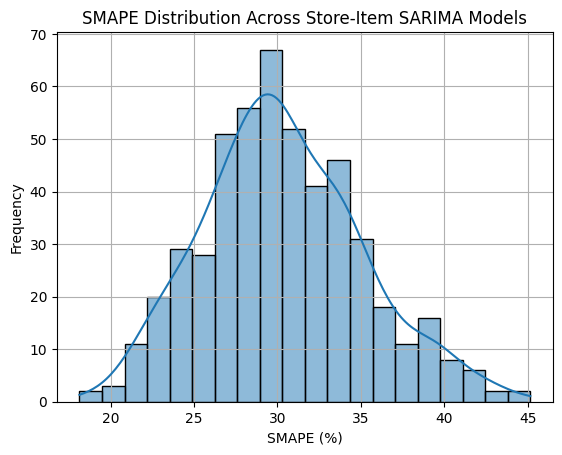

Start → Store 1, Item 17
Result: Store 1, Item 17 | RMSE: 9.07, SMAPE: 28.24%
Start → Store 2, Item 28
Result: Store 2, Item 28 | RMSE: 32.74, SMAPE: 28.24%
Start → Store 3, Item 45
Result: Store 3, Item 45 | RMSE: 24.37, SMAPE: 25.51%
Start → Store 5, Item 10
Result: Store 5, Item 10 | RMSE: 21.19, SMAPE: 35.29%
Start → Store 6, Item 32
Result: Store 6, Item 32 | RMSE: 10.01, SMAPE: 29.11%
Start → Store 8, Item 19
Result: Store 8, Item 19 | RMSE: 17.03, SMAPE: 31.59%
Start → Store 9, Item 31
Result: Store 9, Item 31 | RMSE: 18.37, SMAPE: 28.56%
Start → Store 2, Item 9
Result: Store 2, Item 9 | RMSE: 22.08, SMAPE: 33.51%
Start → Store 2, Item 33
Result: Store 2, Item 33 | RMSE: 22.55, SMAPE: 23.56%
Start → Store 4, Item 12
Result: Store 4, Item 12 | RMSE: 21.05, SMAPE: 26.32%
Start → Store 5, Item 19
Result: Store 5, Item 19 | RMSE: 10.11, SMAPE: 31.46%
Start → Store 6, Item 16
Result: Store 6, Item 16 | RMSE: 6.68, SMAPE: 32.65%
Start → Store 7, Item 29
Result: Store 7, Item 29 | RMSE

In [10]:

sns.histplot(sarima_results_df['smape'], bins=20, kde=True)
plt.title('SMAPE Distribution Across Store-Item SARIMA Models')
plt.xlabel('SMAPE (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


sarima_results_df.to_csv('sarima_results.csv', index=False)


## Try Auto-ARIMA

In [37]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 102.1 MB/s eta 0:00:00


In [ ]:
# from pmdarima import auto_arima
# from sklearn.metrics import mean_absolute_error
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from joblib import Parallel, delayed
# import seaborn as sns
# import warnings

# warnings.filterwarnings("ignore", "FutureWarning")

# # SMAPE metric
# def smape(y_true, y_pred):
#     return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# # Training function
# def train_auto_arima_model(store, item, df, forecast_horizon=30, plot_example=True):
#     print(f"Auto-ARIMA: Store {store}, Item {item}")

#     ts_df = df[(df['store'] == store) & (df['item'] == item)].copy()
#     ts_df = ts_df[['date', 'sales']].set_index('date').sort_index()
#     ts_df = ts_df.asfreq('D')

#     try:
#         time_series = ts_df['sales']
#         train_series = time_series[:-forecast_horizon]
#         eval_series = time_series[-forecast_horizon:]

#         # Fit auto_arima model
#         model = auto_arima(
#             train_series,
#             seasonal=True,
#             m=7,
#             stepwise=True,
#             suppress_warnings=True,
#             error_action='ignore',
#             trace=False,
#             max_p=3, max_q=3, max_P=2, max_Q=2,
#             max_d=2, max_D=1
#         )

#         forecast = model.predict(n_periods=forecast_horizon)

#         # Evaluate using MAE and SMAPE
#         mae_score = mean_absolute_error(eval_series, forecast)
#         smape_score = smape(eval_series, forecast)

#         if plot_example and store == 1 and item in [1, 10]:
#             plt.figure(figsize=(12, 6))
#             plt.plot(eval_series.index, eval_series, label='Actual Sales', color='blue')
#             plt.plot(eval_series.index, forecast, label='Auto-ARIMA Forecast', color='green', linestyle='--')
#             plt.fill_between(eval_series.index, eval_series, forecast, color='gray', alpha=0.2, label='Error')
#             plt.title(f'Store {store}, Item {item} — Auto-ARIMA Forecast', fontsize=16)
#             plt.legend()
#             plt.grid(True)
#             plt.show()

#         print(f"Result: Store {store}, Item {item} | MAE: {mae_score:.2f}, SMAPE: {smape_score:.2f}%")
#         return {
#             'store': store,
#             'item': item,
#             'mae': round(mae_score, 2),
#             'smape': round(smape_score, 2)
#         }

#     except Exception as e:
#         print(f"FAIL: Store {store}, Item {item} — {str(e)}")
#         return None


# # Restrict to 10 stores and 50 items
# store_ids = sorted(train_df['store'].unique())[:10]
# item_ids = sorted(train_df['item'].unique())[:50]
# store_item_pairs = [(s, i) for s in store_ids for i in item_ids]

# print(f"Total Models to Run: {len(store_item_pairs)}")

# # Run models in parallel
# results = Parallel(n_jobs=-1)(
#     delayed(train_auto_arima_model)(store, item, train_df, forecast_horizon=30, plot_example=True)
#     for store, item in store_item_pairs
# )

# # Aggregate results
# results = [r for r in results if r is not None]
# auto_arima_results_df = pd.DataFrame(results)

# print(f"\nFINISHED: {len(auto_arima_results_df)} successful models")



In [ ]:
# # Plot MAE distribution
# plt.figure(figsize=(10, 6))
# sns.histplot(auto_arima_results_df['mae'], kde=True, bins=25, color='salmon')
# plt.title('MAE Distribution Across Store-Item Auto-ARIMA Models')
# plt.xlabel('MAE')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

# #  plot SMAPE distribution too
# plt.figure(figsize=(10, 6))
# sns.histplot(auto_arima_results_df['smape'], kde=True, bins=25, color='skyblue')
# plt.title('SMAPE Distribution Across Store-Item Auto-ARIMA Models')
# plt.xlabel('SMAPE (%)')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

In [ ]:
# auto_arima_results_df

store  item  rmse  smape
0        1     1  6.83  32.59
1        1     2 19.04  32.28
2        1     3  9.51  28.26
3        1     4  7.99  39.57
4        1     5  6.85  38.64
..     ...   ...   ...    ...
495     10    46 22.44  32.94
496     10    47 10.79  40.83
497     10    48 19.45  30.76
498     10    49 11.35  34.97
499     10    50 17.57  21.82

[500 rows x 4 columns]

In [ ]:
# auto_arima_results_df.to_csv("auto_arima_results.csv", index=False)

ARIMA/SARIMA might be a BAD CHOICE for sparse/non-continuous series.SMAPE suffers when either y_true or y_pred is close to 0 — which amplifies % error.

## Error Analysis

In [41]:
# Check sparsity and volatility
train_df['is_zero'] = train_df['sales'] == 0
sparse_ratio = train_df.groupby(['store', 'item'])['is_zero'].mean().reset_index()
sparse_ratio.columns = ['store', 'item', 'zero_ratio']


problematic = sparse_ratio[sparse_ratio['zero_ratio'] > 0.5]
print(f"Sparse Series: {len(problematic)} store-item pairs")


Sparse Series: 0 store-item pairs


- window=7: Looks at the past 3 days, current day, and next 3 days.

- center=True: Aligns the average at the center of the window (e.g. day 4 of the 7).

Why? Sales data is often noisy day-to-day, but smoother weekly patterns emerge.

Z-score measures how far a point is from the mean, in terms of standard deviations.

z = (x - mean) / std — so a z-score of +3 means "3 standard deviations above the average".

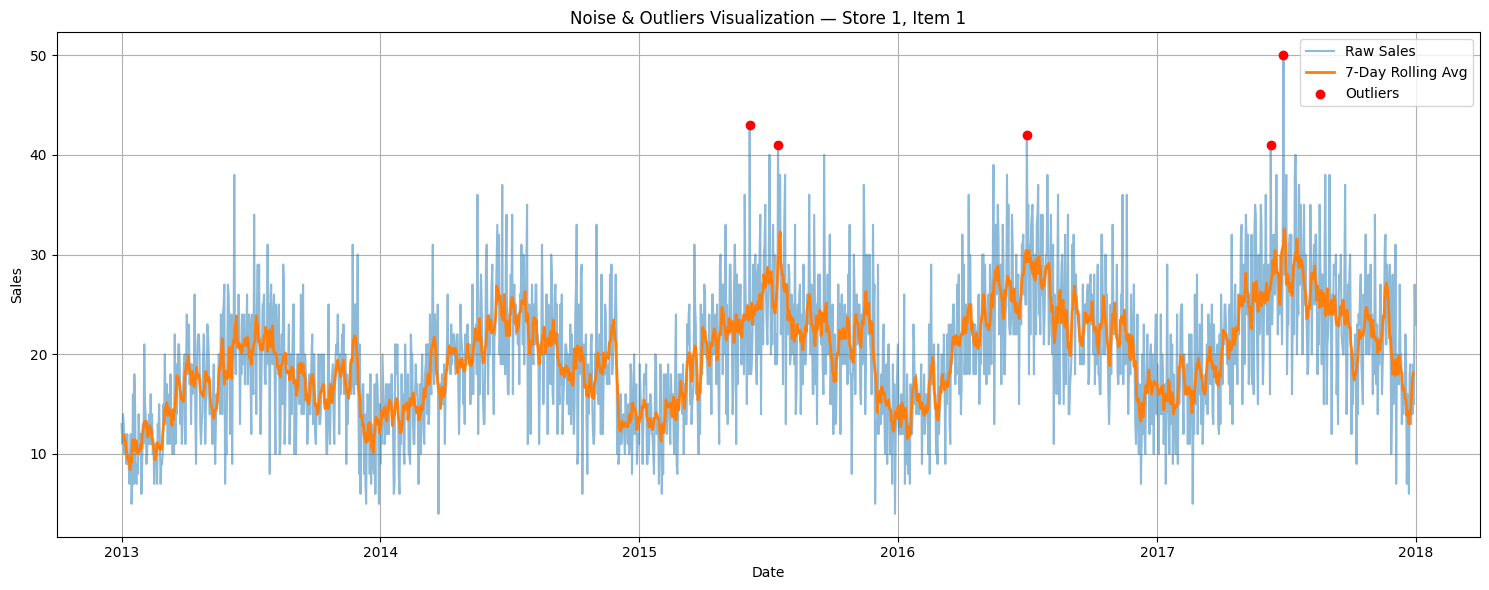

In [ ]:
from scipy.stats import zscore
# Filter for one store-item pair as an example
store, item = 1, 1
ts_df = train_df[(train_df["store"] == store) & (train_df["item"] == item)].copy()
ts_df = ts_df[["date", "sales"]].set_index("date").sort_index()
ts_df = ts_df.asfreq("D")

# Handle missing values
ts_df["sales"] = ts_df["sales"].interpolate(method="linear")
# TODO: Smooth out short-term noise in the daily sales using a 7-day moving average.
# Calculate rolling average 
ts_df["rolling_mean"] = ts_df["sales"].rolling(window=7, center=True).mean()

# Z-score for outlier detection
ts_df["z_score"] = zscore(ts_df["sales"].fillna(0))
ts_df["outlier"] = ts_df["z_score"].abs() > 3

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(ts_df.index, ts_df["sales"], label="Raw Sales", alpha=0.5)
plt.plot(ts_df.index, ts_df["rolling_mean"], label="7-Day Rolling Avg", linewidth=2)
plt.scatter(ts_df.index[ts_df["outlier"]], ts_df["sales"][ts_df["outlier"]],
            color="red", label="Outliers", zorder=5)
plt.title(f"Noise & Outliers Visualization — Store {store}, Item {item}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## SARIMA V.2

In [33]:
from joblib import Parallel, delayed
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter("ignore", UserWarning)


try s = 7

In [34]:
# --- Metrics ---
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

def compute_metrics(y_true, y_pred):
    return {
        'mae': round(mean_absolute_error(y_true, y_pred), 2),
        'rmse': round(root_mean_squared_error(y_true, y_pred), 2),
        'smape': round(smape(y_true, y_pred), 2)
    }

# --- SARIMA Trainer ---
def train_sarima_model(store, item, df, forecast_horizon=30, order=(2, 0, 1), seasonal_order=(1, 1, 1, 7), plot_example=True):
    # print(f"Start → Store {store}, Item {item}")

    train_series, eval_series, ts_df = prepare_ts(df, store, item)

    try:
        model = SARIMAX(
            train_series,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=True,
            enforce_invertibility=True
        )
        print("Train len:", len(train_series), "Eval len:", len(eval_series))

        model_fit = model.fit(disp=False)
        # print(f"FIT OK: Store {store}, Item {item}")

        predictions = model_fit.predict(
            start=len(train_series),
            end=len(train_series) + len(eval_series) - 1,
            dynamic=False
        )

        metrics = compute_metrics(eval_series, predictions)

        if plot_example and store == 1 and item in [1, 10]:
            plt.figure(figsize=(12, 6))
            plt.plot(eval_series.index, eval_series, label='Actual Sales', color='blue')
            plt.plot(eval_series.index, predictions, label='SARIMA Forecast', color='orange', linestyle='--')
            plt.fill_between(eval_series.index, eval_series, predictions, color='gray', alpha=0.2, label='Error')
            plt.title(f'Store {store}, Item {item} — Daily Sales Forecast using SARIMA', fontsize=16)
            plt.legend()
            plt.grid(True)
            plt.show()

        print(f"Result: Store {store}, Item {item} | MAE: {metrics['mae']} | RMSE: {metrics['rmse']} | SMAPE: {metrics['smape']}%")
        return {
            'store': store,
            'item': item,
            **metrics
        }

    except Exception as e:
        print(f"FAIL: Store {store}, Item {item} — {str(e)}")
        return None

# --- Run Models ---
n_jobs = -1
store_ids = train_df['store'].unique()
item_ids = train_df['item'].unique()
store_item_pairs = [(s, i) for s in store_ids for i in item_ids]

print(f"Total Combinations: {len(store_item_pairs)}")

results = Parallel(n_jobs=n_jobs)(
    delayed(train_sarima_model)(store, item, train_df, order=(2, 0, 1), seasonal_order=(1, 1, 1, 7), plot_example=True)
    for store, item in store_item_pairs
)

# Filter and Save Results
results = [r for r in results if r is not None]
sarima_results_df = pd.DataFrame(results)

print(f"\nFINISHED: {len(sarima_results_df)} successful models")

# Show summary statistics
print(sarima_results_df.describe())


Total Combinations: 500


/home/nsamaira/miniconda3/envs/autogluon_ts/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/nsamaira/miniconda3/envs/autogluon_ts/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/nsamaira/miniconda3/envs/autogluon_ts/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/nsamaira/miniconda3/envs/autogluon_ts/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 


FINISHED: 500 successful models
       store   item    mae   rmse  smape
count 500.00 500.00 500.00 500.00 500.00
mean    5.50  25.50  14.74  16.11  30.12
std     2.88  14.45   6.47   6.70   4.75
min     1.00   1.00   3.39   4.15  18.07
25%     3.00  13.00   9.53  10.75  26.87
50%     5.50  25.50  14.21  15.48  29.84
75%     8.00  38.00  19.42  21.03  33.28
max    10.00  50.00  33.18  34.88  44.65


In [35]:
sarima_results_df

store  item   mae  rmse  smape
0        1     1  5.69  6.66  32.37
1        1     2 17.91 18.83  32.55
2        1     3  8.24  9.50  27.67
3        1     4  7.35  7.97  39.32
4        1     5  5.45  6.45  36.43
..     ...   ...   ...   ...    ...
495     10    46 20.46 21.63  31.86
496     10    47  9.77 10.83  41.24
497     10    48 16.28 17.96  29.45
498     10    49  9.98 11.24  34.54
499     10    50 15.06 17.60  21.48

[500 rows x 5 columns]

In [36]:
sarima_results_df.to_csv("sarima_res_s7.csv",index= False)

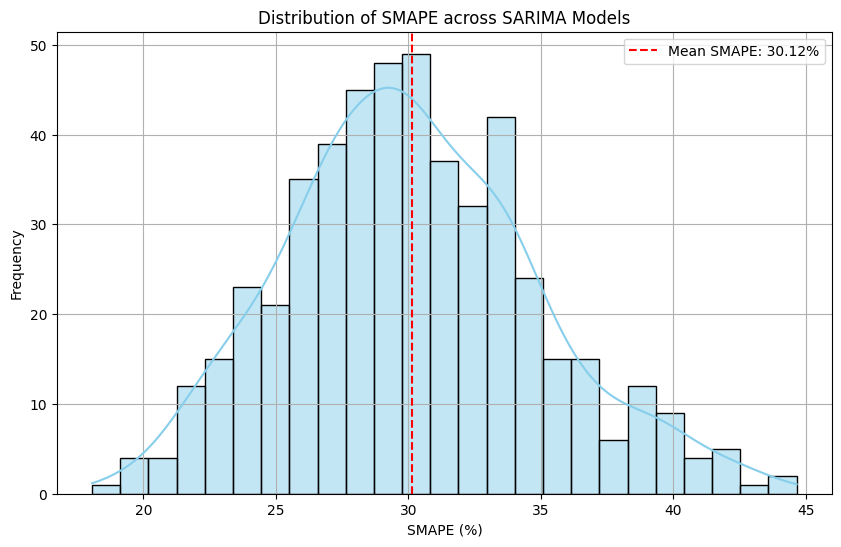

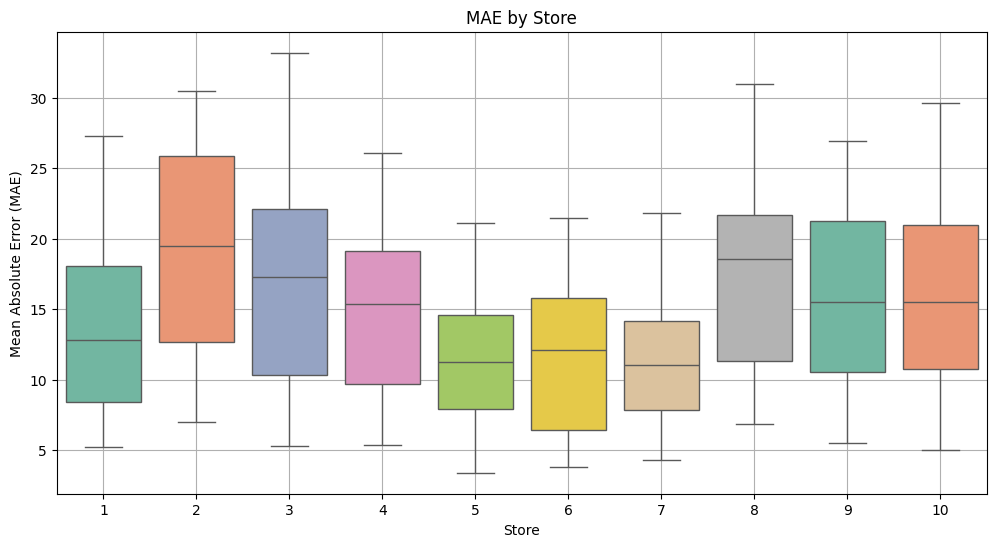

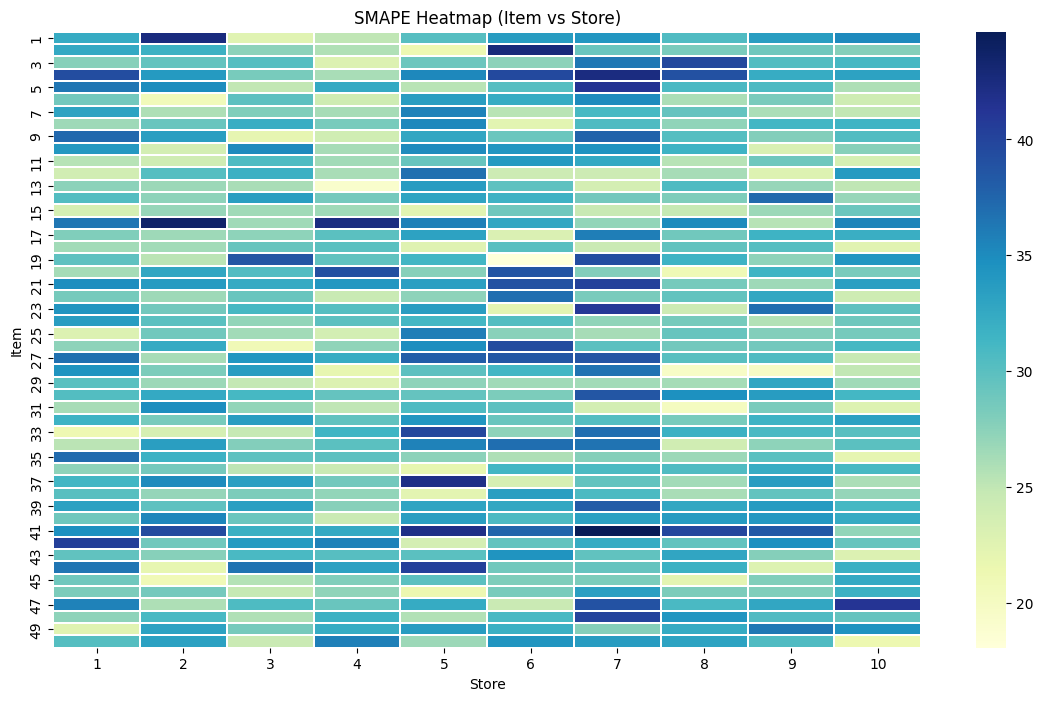

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- SMAPE Distribution ---
plt.figure(figsize=(10, 6))
sns.histplot(sarima_results_df['smape'], bins=25, kde=True, color='skyblue')
plt.axvline(sarima_results_df['smape'].mean(), color='red', linestyle='--', label=f"Mean SMAPE: {sarima_results_df['smape'].mean():.2f}%")
plt.title('Distribution of SMAPE across SARIMA Models')
plt.xlabel('SMAPE (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# --- MAE by Store ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=sarima_results_df, x='store', y='mae', palette='Set2')
plt.title('MAE by Store')
plt.xlabel('Store')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.show()

# --- SMAPE Heatmap: Store vs Item ---
pivot_table = sarima_results_df.pivot(index='item', columns='store', values='smape')
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=False, cmap='YlGnBu', linewidths=0.3)
plt.title('SMAPE Heatmap (Item vs Store)')
plt.xlabel('Store')
plt.ylabel('Item')
plt.show()


SARIMA works reasonably well for a majority of store-item pairs, especially when data is denoised using rolling means and outliers are capped.

30.12% SMAPE as a central tendency is a solid baseline for classical models.

Changing seasonal order from 7 to 52 gave slightly higher average error, and introduced severe instability in a few cases. While most models remained stable, a small number of store-item pairs suffered from data limitations or poor seasonal fit, skewing the overall view.

### Predict and evaluate Test Set

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def get_series(df, store, item):
    ts = df[(df['store'] == store) & (df['item'] == item)]
    ts = ts.set_index('date').asfreq('D')['sales'].fillna(0)
    return ts


In [40]:
def fit_sarima(train_series, order=(2,0,1), seasonal_order=(1,1,1,7)):
    model = SARIMAX(train_series,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=True,
                    enforce_invertibility=True)
    result = model.fit(disp=False)
    return result


In [41]:
def predict_sarima(model_fit, steps):
    
    forecast = model_fit.forecast(steps=steps)
    return forecast


In [ ]:
from tqdm import tqdm

forecast_results = []

grouped_test = test_df.groupby(['store', 'item'])

for (store, item), group in tqdm(grouped_test):
    try:
        train_series = get_series(train_df, store, item)
        model_fit = fit_sarima(train_series)
        preds = predict_sarima(model_fit, steps=len(group))
        
        group = group.copy()
        group['predicted_sales'] = preds.values
        forecast_results.append(group)
        
    except Exception as e:
        print(f"Store {store} Item {item} failed: {e}")


In [76]:
predicted_df = pd.concat(forecast_results)
predicted_df

id       date  store  item  predicted_sales
0          0 2018-01-01      1     1            12.76
1          1 2018-01-02      1     1            15.48
2          2 2018-01-03      1     1            16.00
3          3 2018-01-04      1     1            16.98
4          4 2018-01-05      1     1            18.19
...      ...        ...    ...   ...              ...
44995  44995 2018-03-27     10    50            59.65
44996  44996 2018-03-28     10    50            61.04
44997  44997 2018-03-29     10    50            66.76
44998  44998 2018-03-30     10    50            71.51
44999  44999 2018-03-31     10    50            76.19

[45000 rows x 5 columns]

In [78]:
predicted_df[['date', 'store', 'item', 'predicted_sales']].to_csv("submission_sales_1.csv", index=False)


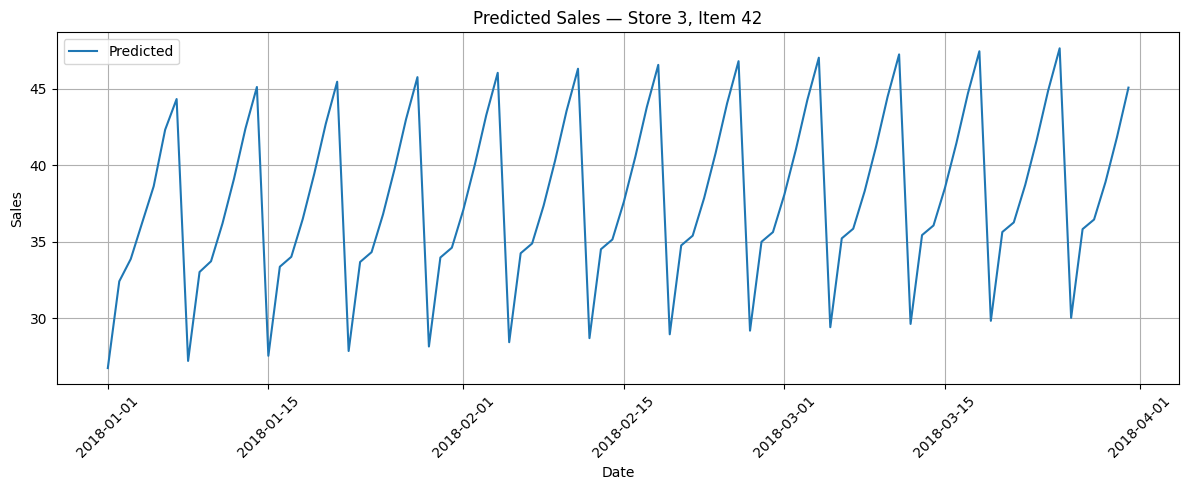

In [80]:

store_id = 3
item_id = 42

subset = predicted_df[(predicted_df['store'] == store_id) & (predicted_df['item'] == item_id)]

plt.figure(figsize=(12, 5))
plt.plot(subset['date'], subset['predicted_sales'], label='Predicted')
plt.title(f"Predicted Sales — Store {store_id}, Item {item_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Multivariate Time Series

## Feature Engineering for XGB

In [7]:
def create_dt_feat(df):
    df['date'] = pd.to_datetime(df['date'])
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.weekday
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofmonth'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_holiday'] = df['date'].apply(lambda x: 1 if x in th_holidays else 0)
    return df


In [44]:
def create_lag_features(df, lags=[7, 14, 28, 42]):
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(['store', 'item'])['sales'].shift(lag)
    return df


In [45]:
def create_rolling_features(df, windows=[7, 14, 28, 42]):
    for win in windows:
        df[f'rolling_mean_{win}'] = df.groupby(['store', 'item'])['sales'].shift(1).rolling(win).mean()
        df[f'rolling_std_{win}'] = df.groupby(['store', 'item'])['sales'].shift(1).rolling(win).std()
    return df


In [46]:
import numpy as np

def create_trend_slope_features(df, window=7):
    def calc_slope(series):
        if series.isnull().any():
            return np.nan
        x = np.arange(len(series))
        y = series.values
        slope = np.polyfit(x, y, 1)[0]
        return slope

    df[f'trend_{window}'] = (
        df.groupby(['store', 'item'])['sales']
        .transform(lambda x: x.shift(1).rolling(window).apply(calc_slope, raw=False))
    )

    return df


In [14]:
!pip install holidays


  Using cached holidays-0.69-py3-none-any.whl.metadata (28 kB)
Using cached holidays-0.69-py3-none-any.whl (863 kB)


In [47]:
import holidays
th_holidays = holidays.Thailand()


## AutoGluon

In [9]:
!pip install autogluon.timeseries


In [16]:
import pandas as pd

train_df['date'] = pd.to_datetime(train_df['date'])

# Combine store and item into a unique series ID
train_df['item_store_id'] = train_df['store'].astype(str) + '_' + train_df['item'].astype(str)


In [17]:
from autogluon.timeseries import TimeSeriesDataFrame,TimeSeriesPredictor

train_df = train_df.rename(columns={'sales': 'target'}) #required

ts_train = TimeSeriesDataFrame.from_data_frame(
    train_df, id_column='item_store_id', timestamp_column='date'
)

predictor = TimeSeriesPredictor(
    path="autogluon_models/",
    prediction_length=90,
    target='target'
)
predictor.fit(ts_train)

Beginning AutoGluon training...
AutoGluon will save models to '/home/nsamaira/autogluon_models'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #60-Ubuntu SMP Thu Jun 13 19:43:39 UTC 2024
CPU Count:          256
GPU Count:          1
Memory Avail:       875.08 GB / 1007.66 GB (86.8%)
Disk Space Avail:   1025776.51 GB / 1976995.02 GB (51.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 90,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 913000 rows, 500 time series. Median time series length is 1826 (min=1826, 

In [28]:
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['item_store_id'] = test_df['store'].astype(str) + '_' + test_df['item'].astype(str)
ts_test = test_df.copy()
ts_test['target'] = np.nan
# AutoGluon expects most recent entry per series for forecasting start
ts_test = TimeSeriesDataFrame.from_data_frame(
    ts_test[['item_store_id', 'date', 'target', 'store', 'item']],  
    id_column='item_store_id',
    timestamp_column='date'
)

In [29]:
ts_test

target  store  item
item_id timestamp                      
1_1     2018-01-01     NaN      1     1
        2018-01-02     NaN      1     1
        2018-01-03     NaN      1     1
        2018-01-04     NaN      1     1
        2018-01-05     NaN      1     1
...                    ...    ...   ...
10_50   2018-03-27     NaN     10    50
        2018-03-28     NaN     10    50
        2018-03-29     NaN     10    50
        2018-03-30     NaN     10    50
        2018-03-31     NaN     10    50

[45000 rows x 3 columns]

In [30]:
forecast = predictor.predict(ts_test)



Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [34]:
forecast_df = forecast.reset_index()
forecast_df = forecast_df.rename(columns={'mean': 'predicted_sales'})

# Split 'item_id' back into 'store' and 'item'
forecast_df[['store', 'item']] = forecast_df['item_id'].str.split('_', expand=True)
forecast_df['store'] = forecast_df['store'].astype(int)
forecast_df['item'] = forecast_df['item'].astype(int)
forecast_df


item_id  timestamp  predicted_sales  0.1  0.2  0.3  0.4  0.5  0.6  0.7  \
0         1_1 2018-04-01             4.54 4.07 4.30 4.42 4.54 4.54 4.86 5.06   
1         1_1 2018-04-02             3.39 2.83 2.91 3.15 3.31 3.39 3.59 3.74   
2         1_1 2018-04-03             3.90 3.33 3.52 3.70 3.85 3.90 4.18 4.32   
3         1_1 2018-04-04             3.88 3.31 3.50 3.69 3.85 3.88 4.18 4.32   
4         1_1 2018-04-05             4.14 3.54 3.77 3.98 4.12 4.14 4.46 4.62   
...       ...        ...              ...  ...  ...  ...  ...  ...  ...  ...   
44995   10_50 2018-06-25             3.75 3.10 3.41 3.56 3.72 3.75 4.05 4.22   
44996   10_50 2018-06-26             4.47 3.69 4.08 4.27 4.44 4.47 4.73 4.93   
44997   10_50 2018-06-27             4.50 3.68 4.09 4.32 4.46 4.50 4.79 4.96   
44998   10_50 2018-06-28             4.83 4.00 4.38 4.58 4.73 4.83 5.10 5.25   
44999   10_50 2018-06-29             5.10 4.24 4.69 4.92 5.09 5.10 5.45 5.63   

       0.8  0.9  store  item  
0     5.07 5.42      1     1  
1     3.88 4.12      1     1  
2     4.54 4.85      1     1  
3     4.53 4.84      1     1  
4     4.76 5.06      1     1  
...    ...  ...    ...   ...  
44995 4.42 4.70     10    50  
44996 5.14 5.47     10    50  
44997 5.15 5.50     10    50  
44998 5.47 5.83     10    50  
44999 5.86 6.27     10    50  

[45000 rows x 14 columns]

In [35]:
forecast_df.to_csv("autogluon_final_results.csv",index=False)

## Pre training

In [48]:
train_df = train_df.rename(columns={'target': 'sales'})


In [49]:
train_df

date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]

In [134]:
# train_df['item_store_id'] = train_df['item'].astype(str) + '_' + train_df['store'].astype(str)

# Apply feature eng
df_feat = train_df.copy()
df_feat = create_dt_feat(df_feat)
# df_feat = create_lag_features(df_feat)
# df_feat = create_rolling_features(df_feat)
# df_feat = create_trend_slope_features(df_feat)

# Drop NA (caused by lags/rolling)
df_feat = df_feat.dropna()



In [135]:
features

['store',
 'item',
 'dayofweek',
 'weekday',
 'week',
 'month',
 'quarter',
 'year',
 'dayofmonth',
 'dayofyear',
 'is_weekend',
 'is_month_start',
 'is_month_end',
 'is_holiday',
 'lag_7',
 'lag_14',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_mean_14',
 'rolling_std_14',
 'rolling_std_28',
 'trend_7']

## XGB

FYI: We're dealing with time series, should split by date, not train_test_split, for better performance

In [138]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# X_train, X_val, y_train, y_val = train_test_split(df_feat[features], df_feat[target], test_size=0.2, random_state=42)
# Sort by date first to respect time order
df_feat = df_feat.sort_values("date")
df_feat['sales'] = df_feat['sales'].astype(float).bfill().ffill()

# Smooth
df_feat['sales_smooth'] = df_feat['sales'].rolling(window=7, center=True).mean()

# Z-score
from scipy.stats import zscore
df_feat['z_score'] = zscore(df_feat['sales'].fillna(0))
df_feat['outlier'] = df_feat['z_score'].abs() > 3

# Cap outliers with rolling mean
df_feat['sales_clean'] = df_feat['sales']
df_feat.loc[df_feat['outlier'], 'sales_clean'] = df_feat['sales_smooth']

# Replace target in df_feat before modeling
df_feat['sales'] = df_feat['sales_clean']
# Drop intermediate columns used only for outlier handling
df_feat = df_feat.drop(columns=["sales_smooth", "z_score", "outlier","sales_clean"], errors="ignore")

# df_feat.drop(columns=["lag_28","lag_42","rolling_mean_42","rolling_mean_28","rolling_std_42"], inplace=True)
df_feat


date  store  item  sales  dayofweek  weekday  week  month  \
0      2013-01-01      1     1  13.00          1        1     1      1   
677446 2013-01-01      2    38  50.00          1        1     1      1   
624492 2013-01-01      3    35  38.00          1        1     1      1   
661012 2013-01-01      3    37   9.00          1        1     1      1   
659186 2013-01-01      2    37  18.00          1        1     1      1   
...           ...    ...   ...    ...        ...      ...   ...    ...   
1825   2017-12-31      1     1  23.00          6        6    52     12   
51127  2017-12-31      8     3  59.00          6        6    52     12   
54779  2017-12-31     10     3  39.00          6        6    52     12   
21911  2017-12-31      2     2  79.00          6        6    52     12   
912999 2017-12-31     10    50  82.00          6        6    52     12   

        quarter  year  dayofmonth  dayofyear  is_weekend  is_month_start  \
0             1  2013           1          1           0               1   
677446        1  2013           1          1           0               1   
624492        1  2013           1          1           0               1   
661012        1  2013           1          1           0               1   
659186        1  2013           1          1           0               1   
...         ...   ...         ...        ...         ...             ...   
1825          4  2017          31        365           1               0   
51127         4  2017          31        365           1               0   
54779         4  2017          31        365           1               0   
21911         4  2017          31        365           1               0   
912999        4  2017          31        365           1               0   

        is_month_end  is_holiday  
0                  0           1  
677446             0           1  
624492             0           1  
661012             0           1  
659186             0           1  
...              ...         ...  
1825               1           1  
51127              1           1  
54779              1           1  
21911              1           1  
912999             1           1  

[913000 rows x 16 columns]

In [139]:
# Define features
target = 'sales'
features = [col for col in df_feat.columns if col not in ['sales', 'date']] # don't drop store, item

In [140]:
# Time-aware split: 80% train, 20% validation (latest data)
split_point = int(len(df_feat) * 0.8)

X_train = df_feat.iloc[:split_point][features]
y_train = df_feat.iloc[:split_point][target]

X_val = df_feat.iloc[split_point:][features]
y_val = df_feat.iloc[split_point:][target]
# X_train, X_val, y_train, y_val = train_test_split(df_feat[features], df_feat[target], test_size=0.2, random_state=42)
xgb_model = xgb.XGBRegressor(
    n_estimators=2449,
    max_depth=16,
    learning_rate=0.0997,
    subsample=0.65,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:27.66900
[1]	validation_0-rmse:25.80761
[2]	validation_0-rmse:25.34050
[3]	validation_0-rmse:23.65958
[4]	validation_0-rmse:22.23297
[5]	validation_0-rmse:21.65278
[6]	validation_0-rmse:21.16986
[7]	validation_0-rmse:19.85820
[8]	validation_0-rmse:18.77466
[9]	validation_0-rmse:17.86544
[10]	validation_0-rmse:16.98937
[11]	validation_0-rmse:16.19649
[12]	validation_0-rmse:15.55396
[13]	validation_0-rmse:14.90294
[14]	validation_0-rmse:14.30031
[15]	validation_0-rmse:14.08633
[16]	validation_0-rmse:13.51712
[17]	validation_0-rmse:13.07731
[18]	validation_0-rmse:12.68607
[19]	validation_0-rmse:12.32527
[20]	validation_0-rmse:12.07308
[21]	validation_0-rmse:11.73023
[22]	validation_0-rmse:11.48090
[23]	validation_0-rmse:11.25698
[24]	validation_0-rmse:10.99405
[25]	validation_0-rmse:10.78585
[26]	validation_0-rmse:10.58372
[27]	validation_0-rmse:10.47278
[28]	validation_0-rmse:10.30142
[29]	validation_0-rmse:10.24412
[30]	validation_0-rmse:10.10579
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0997, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2449, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [141]:
# Evaluation
pred = xgb_model.predict(X_val)
rmse = root_mean_squared_error(y_val, pred)
mae = mean_absolute_error(y_val, pred)
# smape = smape(y_val,pred)
print(f"Validation RMSE: {rmse}")
print(f"Validation MAE: {mae}")
# print(f"Validation SMAPE: {smape}")

Validation RMSE: 10.349061160245094
Validation MAE: 7.636844550745981


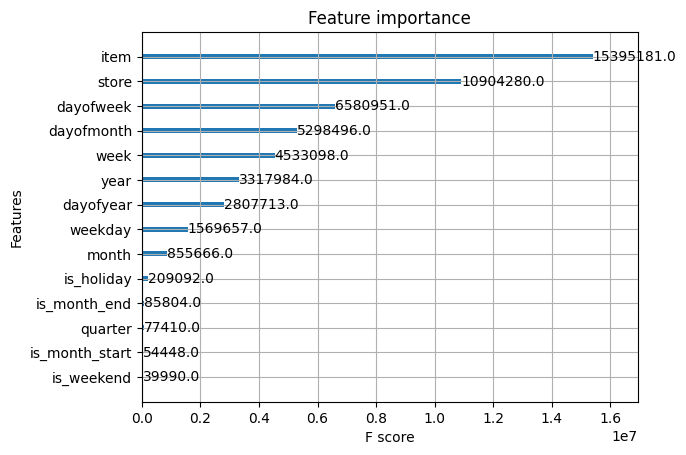

In [142]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()


## Optuna XGB 

In [56]:
import optuna
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

# df_feat = df_feat.sort_values("date")
# df_feat['sales'] = df_feat['sales'].astype(float).bfill().ffill()

# # Smooth
# df_feat['sales_smooth'] = df_feat['sales'].rolling(window=7, center=True).mean()

# # Z-score
# from scipy.stats import zscore
# df_feat['z_score'] = zscore(df_feat['sales'].fillna(0))
# df_feat['outlier'] = df_feat['z_score'].abs() > 3

# # Cap outliers with rolling mean
# df_feat['sales_clean'] = df_feat['sales']
# df_feat.loc[df_feat['outlier'], 'sales_clean'] = df_feat['sales_smooth']

# # Replace target in df_feat before modeling
# df_feat['sales'] = df_feat['sales_clean']

# Time-aware split: 80% train, 20% validation (latest data)
split_point = int(len(df_feat) * 0.8)

X_train = df_feat.iloc[:split_point][features]
y_train = df_feat.iloc[:split_point][target]

X_val = df_feat.iloc[split_point:][features]
y_val = df_feat.iloc[split_point:][target]

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 800, 4000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'tree_method': 'hist',
        'random_state': 42,
        'eval_metric': 'rmse', 
        'n_jobs': -1
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
    )
    
    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    return rmse


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=900)  


In [119]:
print(X_train.columns)

Index(['store', 'item', 'dayofweek', 'weekday', 'week', 'month', 'quarter',
       'year', 'dayofmonth', 'dayofyear', 'is_weekend', 'is_month_start',
       'is_month_end', 'is_holiday', 'lag_7', 'lag_14', 'rolling_mean_7',
       'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_std_28',
       'trend_7'],
      dtype='object')


### Predict on test set

In [154]:
# clearly define test features (no sales-related features!)
test_df = create_dt_feat(test_df)

# test features only columns defined earlier (no lags, rolling, trend!)
X_test = test_df[features].copy()


In [149]:
assert test_df['date'].isnull().sum() == 0, "Dates must not be NaT or NaN!"


In [155]:
print(test_df[['is_holiday']].dtypes)


is_holiday    int64
dtype: object


In [156]:
# Convert `is_holiday` to numeric explicitly (integer)
test_df['is_holiday'] = test_df['is_holiday'].astype(int)
# test features only columns defined earlier (no lags, rolling, trend!)
X_test = test_df[features].copy()


In [157]:
print("Train features:", X_train.columns.tolist())
print("Test features:", X_test.columns.tolist())


Train features: ['store', 'item', 'dayofweek', 'weekday', 'week', 'month', 'quarter', 'year', 'dayofmonth', 'dayofyear', 'is_weekend', 'is_month_start', 'is_month_end', 'is_holiday']
Test features: ['store', 'item', 'dayofweek', 'weekday', 'week', 'month', 'quarter', 'year', 'dayofmonth', 'dayofyear', 'is_weekend', 'is_month_start', 'is_month_end', 'is_holiday']


In [158]:
# Make predictions
test_df["predicted_sales"] = xgb_model.predict(X_test)

# Save predictions
test_df[['date', 'store', 'item', 'predicted_sales']].to_csv("xgb_test_predictions.csv", index=False)


In [159]:
test_df

id       date  store  item  dayofweek  weekday  week  month  \
0          0 2018-01-01      1     1          0        0     1      1   
1          1 2018-01-02      1     1          1        1     1      1   
2          2 2018-01-03      1     1          2        2     1      1   
3          3 2018-01-04      1     1          3        3     1      1   
4          4 2018-01-05      1     1          4        4     1      1   
...      ...        ...    ...   ...        ...      ...   ...    ...   
44995  44995 2018-03-27     10    50          1        1    13      3   
44996  44996 2018-03-28     10    50          2        2    13      3   
44997  44997 2018-03-29     10    50          3        3    13      3   
44998  44998 2018-03-30     10    50          4        4    13      3   
44999  44999 2018-03-31     10    50          5        5    13      3   

       quarter  year  dayofmonth  dayofyear  is_weekend  is_month_start  \
0            1  2018           1          1           0               1   
1            1  2018           2          2           0               0   
2            1  2018           3          3           0               0   
3            1  2018           4          4           0               0   
4            1  2018           5          5           0               0   
...        ...   ...         ...        ...         ...             ...   
44995        1  2018          27         86           0               0   
44996        1  2018          28         87           0               0   
44997        1  2018          29         88           0               0   
44998        1  2018          30         89           0               0   
44999        1  2018          31         90           1               0   

       is_month_end  is_holiday  predicted_sales  
0                 0           1            15.65  
1                 0           1            14.77  
2                 0           0            17.63  
3                 0           0            11.88  
4                 0           0            11.54  
...             ...         ...              ...  
44995             0           0            65.89  
44996             0           0            63.53  
44997             0           0            73.21  
44998             0           0            74.31  
44999             1           0            72.84  

[45000 rows x 17 columns]

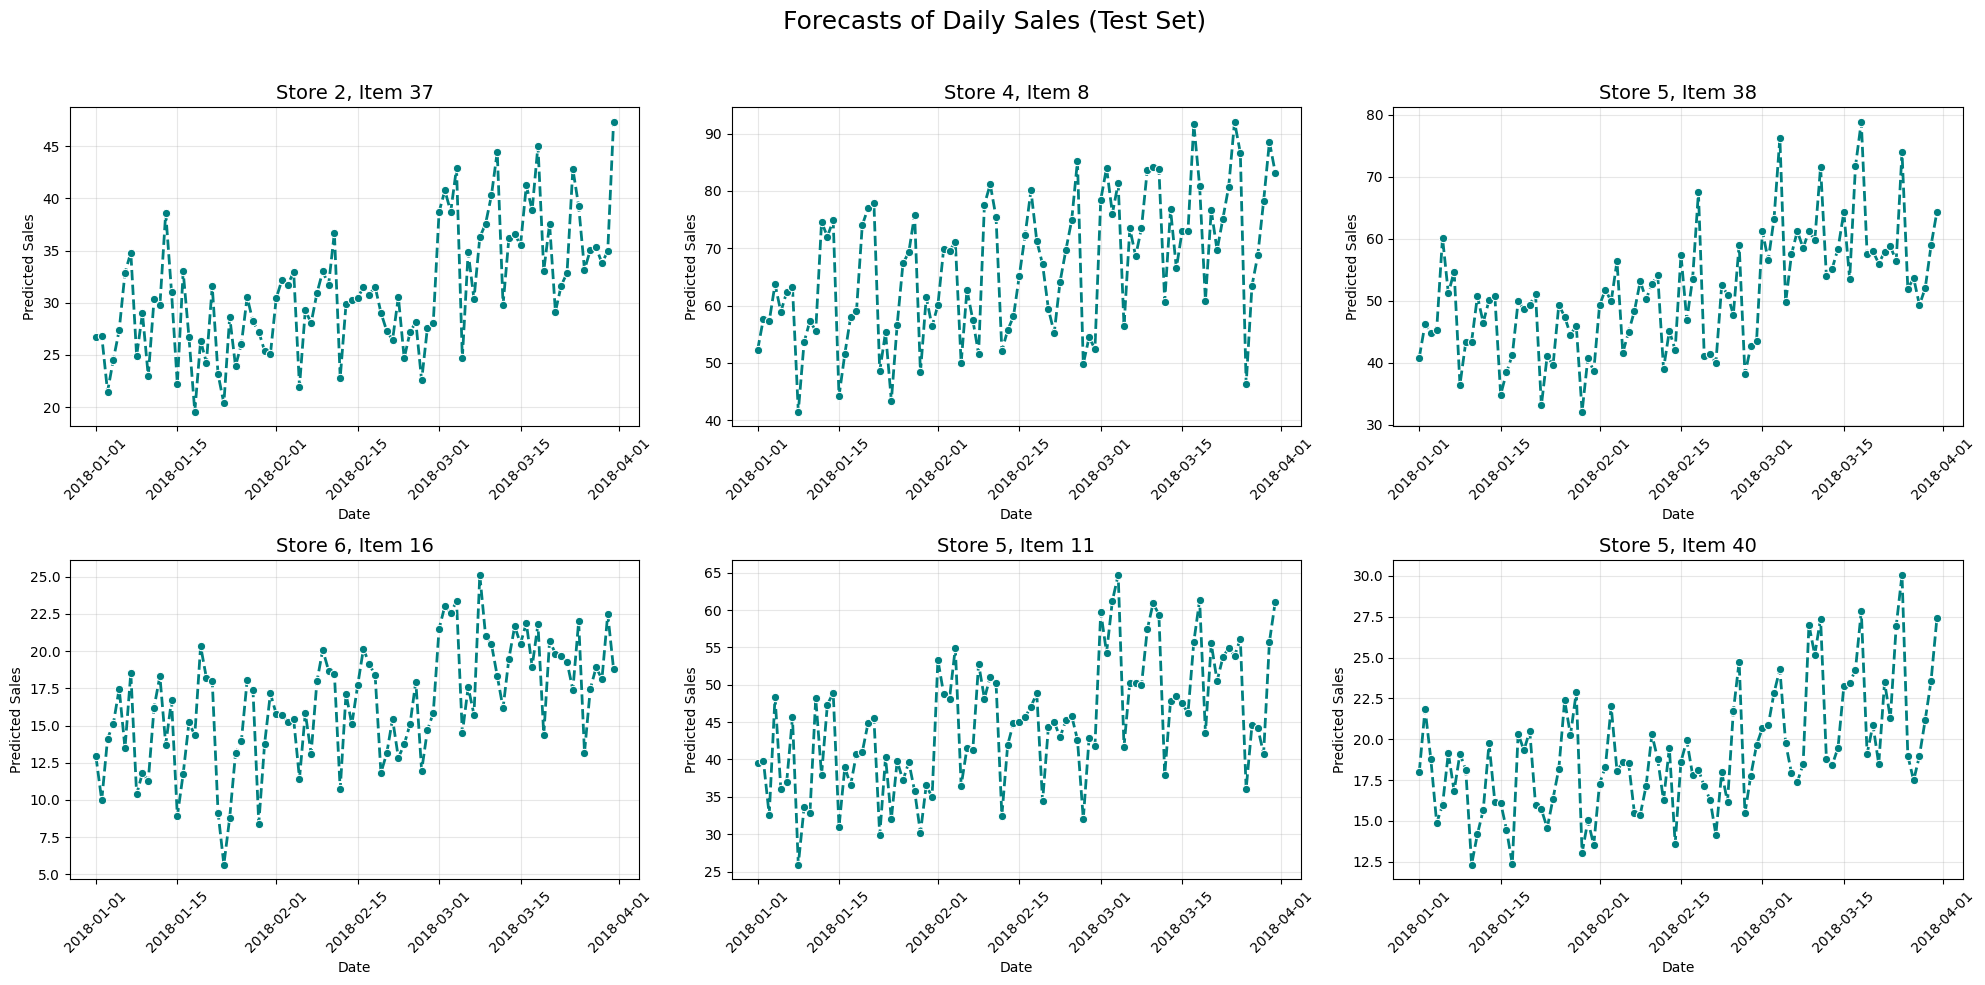

In [163]:
sample_viz_df = test_df[['store', 'item']].drop_duplicates().sample(6, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)

# Loop to plot each pair
for ax, (idx, row) in zip(axes.flatten(), sample_viz_df.iterrows()):
    store, item = row['store'], row['item']
    
    # clearly filter data for selected store-item
    viz_df = test_df[
        (test_df['store'] == store) & (test_df['item'] == item)
    ].sort_values("date")

    # clearly plot forecast
    sns.lineplot(
        data=viz_df, x="date", y="predicted_sales",
        marker='o', linestyle='--', color='teal',
        linewidth=2, ax=ax
    )

    ax.set_title(f"Store {store}, Item {item}", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Predicted Sales")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("Forecasts of Daily Sales (Test Set)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Feature Importance

(Before I decided not to use rolling and lag)

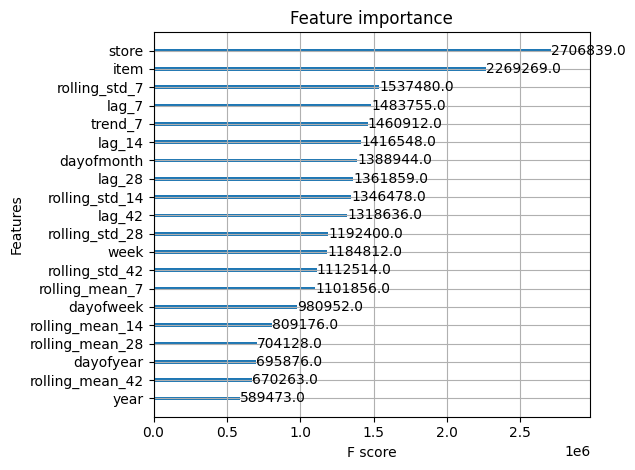

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, max_num_features=20)
plt.tight_layout()
plt.show()


## LightGBM

REMOVE SOME REDUNDANT FEATURES LIKE LAG, ROLLING_MEAN

In [164]:
# df_feat.drop(columns=["lag_28","lag_42","rolling_mean_42","rolling_mean_28","rolling_std_42"], inplace=True)
df_feat

date  store  item  sales  dayofweek  weekday  week  month  \
0      2013-01-01      1     1  13.00          1        1     1      1   
677446 2013-01-01      2    38  50.00          1        1     1      1   
624492 2013-01-01      3    35  38.00          1        1     1      1   
661012 2013-01-01      3    37   9.00          1        1     1      1   
659186 2013-01-01      2    37  18.00          1        1     1      1   
...           ...    ...   ...    ...        ...      ...   ...    ...   
1825   2017-12-31      1     1  23.00          6        6    52     12   
51127  2017-12-31      8     3  59.00          6        6    52     12   
54779  2017-12-31     10     3  39.00          6        6    52     12   
21911  2017-12-31      2     2  79.00          6        6    52     12   
912999 2017-12-31     10    50  82.00          6        6    52     12   

        quarter  year  dayofmonth  dayofyear  is_weekend  is_month_start  \
0             1  2013           1          1           0               1   
677446        1  2013           1          1           0               1   
624492        1  2013           1          1           0               1   
661012        1  2013           1          1           0               1   
659186        1  2013           1          1           0               1   
...         ...   ...         ...        ...         ...             ...   
1825          4  2017          31        365           1               0   
51127         4  2017          31        365           1               0   
54779         4  2017          31        365           1               0   
21911         4  2017          31        365           1               0   
912999        4  2017          31        365           1               0   

        is_month_end  is_holiday  
0                  0           1  
677446             0           1  
624492             0           1  
661012             0           1  
659186             0           1  
...              ...         ...  
1825               1           1  
51127              1           1  
54779              1           1  
21911              1           1  
912999             1           1  

[913000 rows x 16 columns]

In [165]:
target = "sales"
features = [col for col in df_feat.columns if col not in ["date", "sales"]]


In [166]:
# Sort data
df_feat = df_feat.sort_values("date")

# Split by cutoff date (e.g., last 30 days as test)
cutoff_date = df_feat["date"].max() - pd.Timedelta(days=30)
train = df_feat[df_feat["date"] < cutoff_date]
test = df_feat[df_feat["date"] >= cutoff_date]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [167]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.009,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1,
}

model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    num_boost_round=1000,
)


In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

preds = model.predict(X_test, num_iteration=model.best_iteration)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 0.0261
RMSE: 0.0409


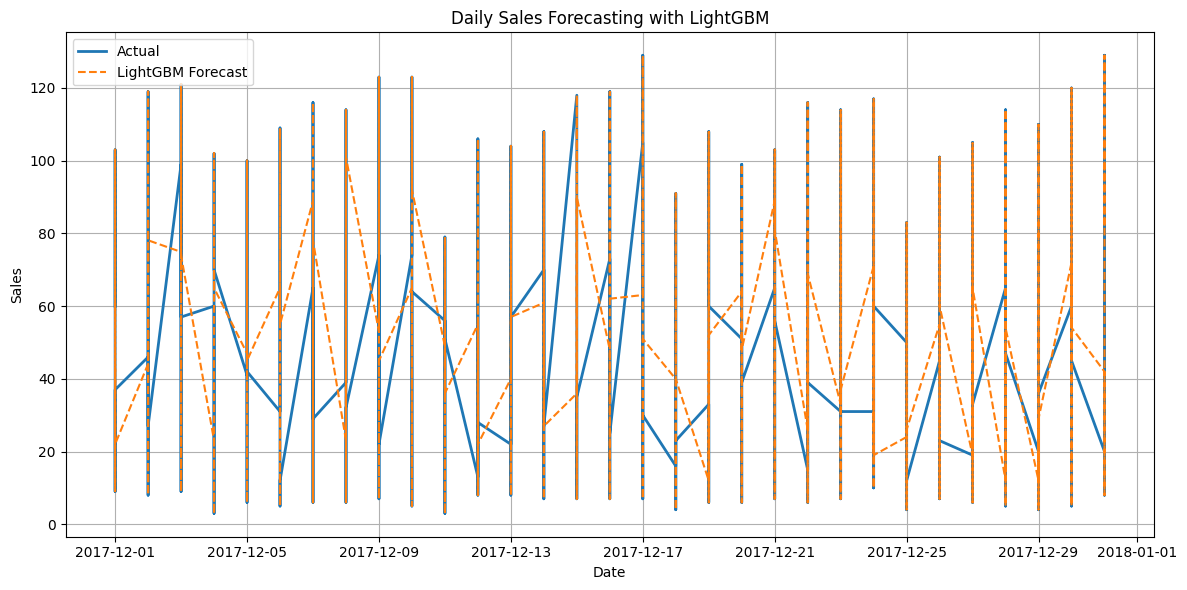

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test["date"], y_test.values, label="Actual", linewidth=2)
plt.plot(test["date"], preds, label="LightGBM Forecast", linestyle="--")
plt.title("Daily Sales Forecasting with LightGBM")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [169]:
missing = [f for f in features if f not in test_df.columns]
print("Missing features in test_df:", missing)


Missing features in test_df: []


In [ ]:

test_df = create_dt_feat(test_df)

test_df['is_holiday'] = test_df['is_holiday'].astype(int)
X_test = test_df[features].copy()
# Make predictions
test_df["predicted_sales"] = model.predict(X_test)

# Save predictions
test_df[['date', 'store', 'item', 'predicted_sales']].to_csv("lgbm_test_predictions.csv", index=False)


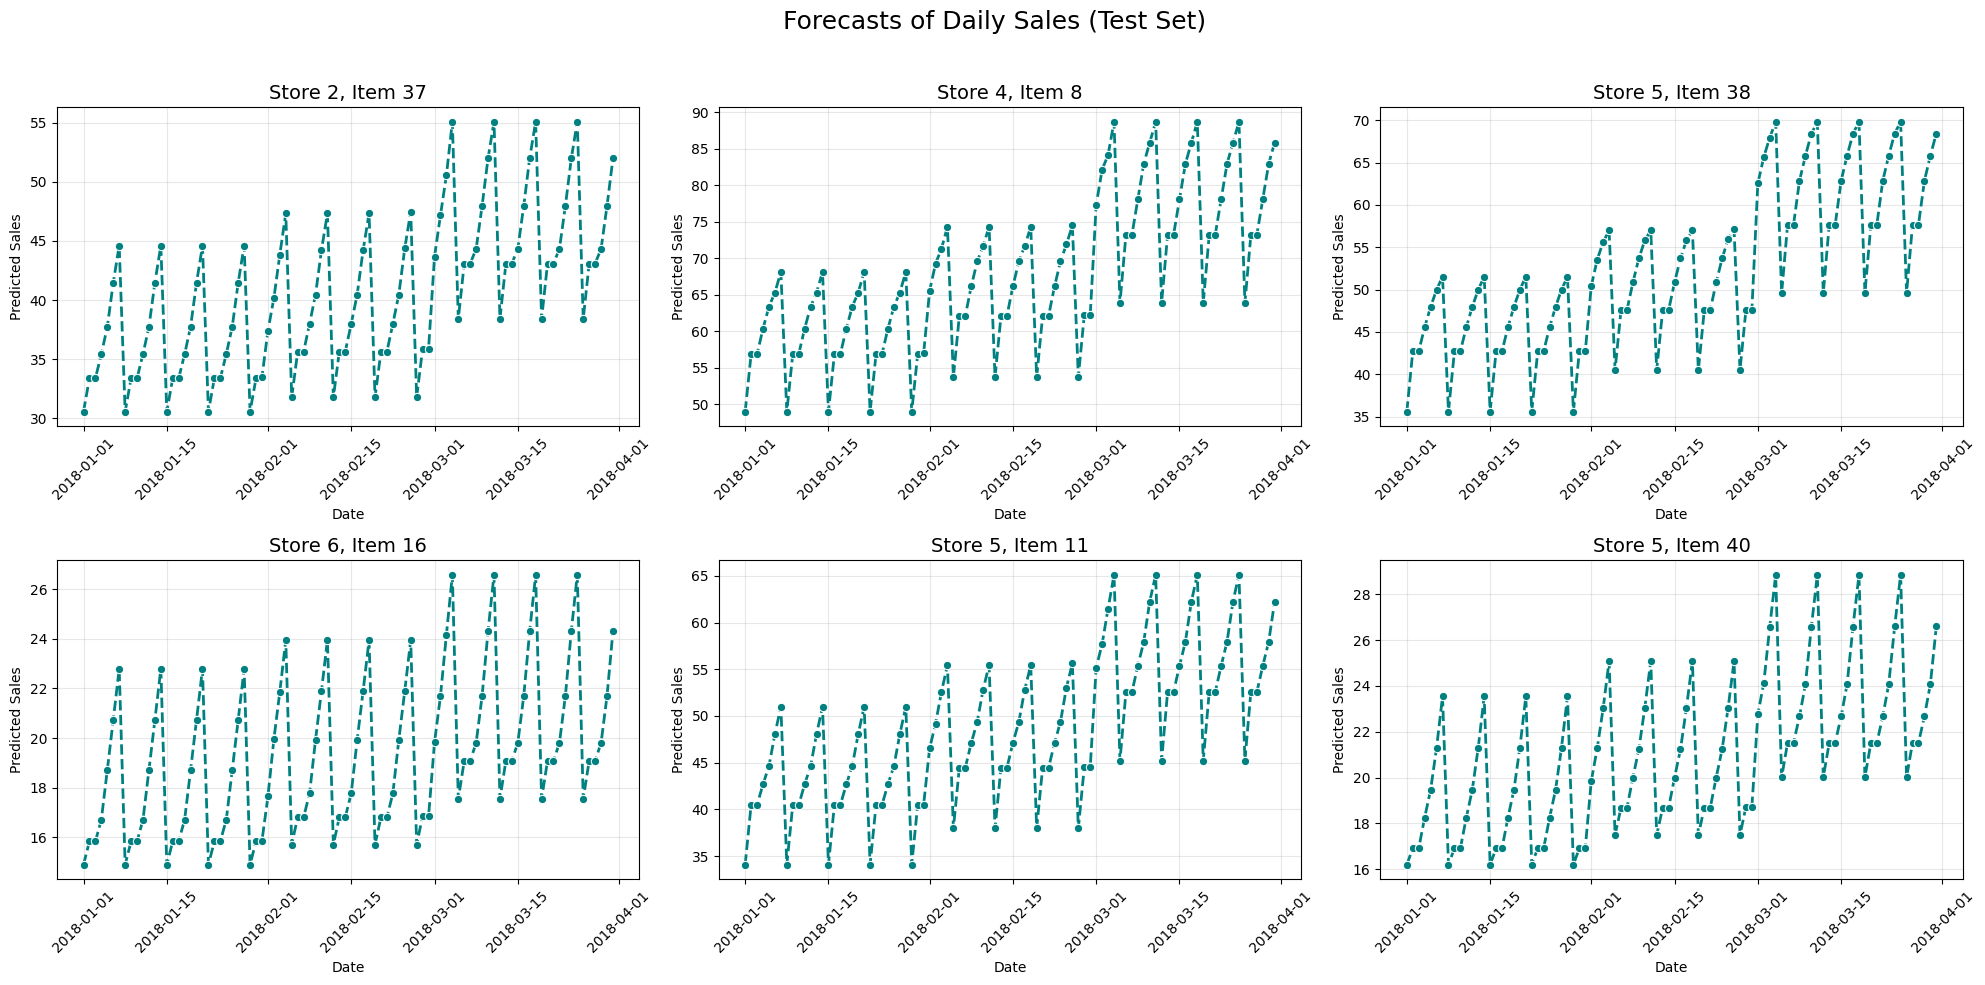

In [172]:
sample_viz_df = test_df[['store', 'item']].drop_duplicates().sample(6, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)

# Loop to plot each pair
for ax, (idx, row) in zip(axes.flatten(), sample_viz_df.iterrows()):
    store, item = row['store'], row['item']
    
    # clearly filter data for selected store-item
    viz_df = test_df[
        (test_df['store'] == store) & (test_df['item'] == item)
    ].sort_values("date")

    # clearly plot forecast
    sns.lineplot(
        data=viz_df, x="date", y="predicted_sales",
        marker='o', linestyle='--', color='teal',
        linewidth=2, ax=ax
    )

    ax.set_title(f"Store {store}, Item {item}", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Predicted Sales")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("Forecasts of Daily Sales (Test Set)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Linear, Lasso, Ridge Regression

In [24]:
train_df

date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]

In [182]:
# Apply feature eng
df_feat = train_df.copy()
df_feat = create_dt_feat(df_feat)
# df_feat = create_lag_features(df_feat)
# df_feat = create_rolling_features(df_feat)
# df_feat = create_trend_slope_features(df_feat)

# # # Drop NA (caused by lags/rolling)
# df_feat = df_feat.dropna()

# Define features
target = 'sales'
feature_cols = [col for col in df_feat.columns if col not in ['date', 'sales']]

In [174]:
feature_cols

['store',
 'item',
 'dayofweek',
 'weekday',
 'week',
 'month',
 'quarter',
 'year',
 'dayofmonth',
 'dayofyear',
 'is_weekend',
 'is_month_start',
 'is_month_end',
 'is_holiday']

In [183]:
df_feat = df_feat.sort_values('date')
cutoff_date = df_feat['date'].max() - pd.Timedelta(days=30)
train = df_feat[df_feat['date'] < cutoff_date]
test = df_feat[df_feat['date'] >= cutoff_date]

In [184]:
X_train, y_train = train[feature_cols], train[target]
X_test, y_test = test[feature_cols], test[target]

In [177]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [185]:
regression_models = {
    'Linear': LinearRegression(),
    'Lasso': Lasso(alpha=0.009),
    'Ridge': Ridge(alpha=0.009)
}

In [186]:
results = {}

for name, model in regression_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(root_mean_squared_error(y_test, preds))
    results[name] = {'MAE': mae, 'RMSE': rmse, 'Predictions': preds}

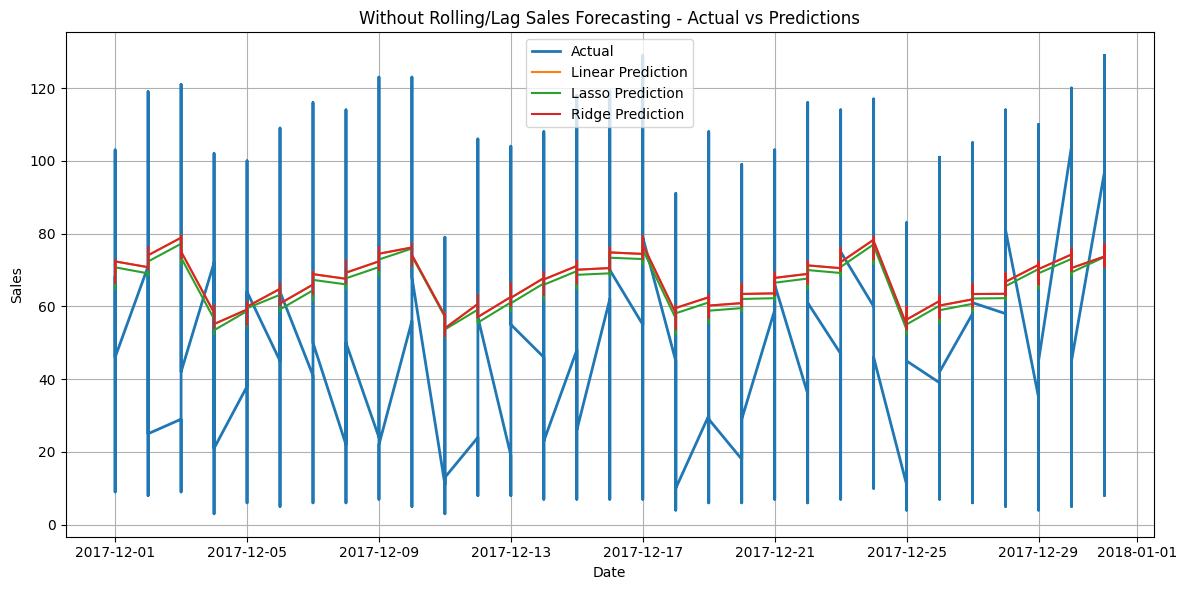

In [187]:
plt.figure(figsize=(12, 6))
plt.plot(test['date'], y_test.values, label='Actual', linewidth=2)
for name in regression_models:
    plt.plot(test['date'], results[name]['Predictions'], label=f'{name} Prediction')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Without Rolling/Lag Sales Forecasting - Actual vs Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [188]:
reg_res = pd.DataFrame(results).T[['MAE', 'RMSE']]
reg_res

MAE RMSE
Linear 26.53 5.57
Lasso  25.71 5.49
Ridge  26.53 5.57

In [37]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 892000 entries, 42 to 912999
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             892000 non-null  datetime64[ns]
 1   store            892000 non-null  int64         
 2   item             892000 non-null  int64         
 3   sales            892000 non-null  int64         
 4   dayofweek        892000 non-null  int32         
 5   weekday          892000 non-null  int32         
 6   week             892000 non-null  int64         
 7   month            892000 non-null  int32         
 8   quarter          892000 non-null  int32         
 9   year             892000 non-null  int32         
 10  dayofmonth       892000 non-null  int32         
 11  dayofyear        892000 non-null  int32         
 12  is_weekend       892000 non-null  int64         
 13  is_month_start   892000 non-null  int64         
 14  is_month_end     892000 

## Chronos-T5  -- small

In [ ]:
# !rm /home/nsamaira/miniconda3/envs/autogluon_ts/lib/python3.10/site-packages/chronos.py


In [25]:
!pip uninstall -y chronos chronos_forecast chronos-forecasting

!pip install -U git+https://github.com/amazon-science/chronos-forecasting.git


Found existing installation: chronos-forecast 0.1.0
Uninstalling chronos-forecast-0.1.0:
  Successfully uninstalled chronos-forecast-0.1.0
Found existing installation: chronos-forecasting 1.5.0
Uninstalling chronos-forecasting-1.5.0:
  Successfully uninstalled chronos-forecasting-1.5.0
  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-xwzn2riw
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-xwzn2riw
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.0-py3-none-any.whl size=29408 sha256=b17f84325bd5ed0f4757227997214e2c0d3b4452ab26432d87109511a2d61873
  Stored in directory: /tmp/pip-ephem-whee

In [9]:
def format_chronos_data(df, is_test=False):
    df_chronos = df.copy()
    df_chronos['ds'] = pd.to_datetime(df_chronos['date'])
    df_chronos['unique_id'] = df_chronos['store'].astype(str) + '_' + df_chronos['item'].astype(str)

    if is_test:
        df_chronos['y'] = None
    else:
        df_chronos = df_chronos.rename(columns={'sales': 'y'})
    
    df_chronos = df_chronos[['unique_id', 'ds', 'y']]
    return df_chronos

chronos_train_df = format_chronos_data(train_df, is_test=False)
chronos_test_df = format_chronos_data(test_df, is_test=True)

In [9]:
chronos_train_df


unique_id         ds   y
0            1_1 2013-01-01  13
1            1_1 2013-01-02  11
2            1_1 2013-01-03  14
3            1_1 2013-01-04  13
4            1_1 2013-01-05  10
...          ...        ...  ..
912995     10_50 2017-12-27  63
912996     10_50 2017-12-28  59
912997     10_50 2017-12-29  74
912998     10_50 2017-12-30  62
912999     10_50 2017-12-31  82

[913000 rows x 3 columns]

In [10]:
chronos_test_df

unique_id         ds     y
0           1_1 2018-01-01  None
1           1_1 2018-01-02  None
2           1_1 2018-01-03  None
3           1_1 2018-01-04  None
4           1_1 2018-01-05  None
...         ...        ...   ...
44995     10_50 2018-03-27  None
44996     10_50 2018-03-28  None
44997     10_50 2018-03-29  None
44998     10_50 2018-03-30  None
44999     10_50 2018-03-31  None

[45000 rows x 3 columns]

convert the historical values into PyTorch tensors

In [10]:
import torch

# Get list of series (each as a tensor)
series_list = []

for uid in chronos_test_df["unique_id"].unique():
    series = chronos_train_df[chronos_train_df["unique_id"] == uid].sort_values("ds")["y"]
    series_tensor = torch.tensor(series.values[-60:], dtype=torch.bfloat16)  # context_length = 60
    series_list.append(series_tensor)


In [15]:
series_list

[tensor([21., 18., 34., 23., 17., 23., 14., 21., 19., 24., 27., 22., 16., 19.,
         22., 25., 31., 32., 21., 29., 27., 25., 22., 29., 24., 10., 14., 28.,
         15., 19., 16., 31.,  7., 20., 17., 18., 17., 27., 20., 20., 13., 17.,
         14., 16., 15., 22., 19.,  7., 16., 12.,  6., 18., 19., 13., 16., 14.,
         19., 15., 27., 23.], dtype=torch.bfloat16),
 tensor([35., 33., 46., 38., 28., 28., 29., 28., 32., 38., 33., 21., 32., 19.,
         28., 34., 45., 45., 27., 41., 33., 41., 38., 26., 44., 29., 36., 24.,
         31., 31., 24., 20., 10., 14., 12., 21., 27., 29., 29., 16., 20., 23.,
         18., 25., 30., 45., 20., 16., 19., 21., 28., 18., 28., 18., 25., 19.,
         21., 18., 24., 31.], dtype=torch.bfloat16),
 tensor([29., 32., 41., 32., 22., 27., 31., 33., 23., 34., 27., 24., 26., 33.,
         27., 34., 30., 34., 33., 32., 27., 23., 31., 29., 30., 27., 24., 32.,
         27., 19., 31., 26., 17., 21., 28., 17., 26., 29., 28., 19., 18., 26.,
         31., 20., 32., 1

In [36]:
import chronos
print(chronos.__file__)


/home/nsamaira/miniconda3/envs/autogluon_ts/lib/python3.10/site-packages/chronos.py


In [25]:
import os
os.getcwd()


'/home/nsamaira'

In [43]:
import sys
sys.path.append("/home/nsamaira/chronos-forecasting/src/chronos") 


In [39]:
print(os.path.exists("/home/nsamaira/chronos-forecasting/src/chronos/base.py"))

True


In [11]:
!find /home/nsamaira/miniconda3/envs/autogluon_ts/lib/python3.10/site-packages/ -name "chronos.py"

/home/nsamaira/miniconda3/envs/autogluon_ts/lib/python3.10/site-packages/autogluon/timeseries/models/chronos/pipeline/chronos.py


In [26]:
import torch
# import os
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="auto",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

# Inference
forecast_tensor = pipeline.predict(
    context=series_list,
    prediction_length=90,  # 3 months
    num_samples=20
)


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


In [27]:
import numpy as np

uids = chronos_test_df["unique_id"].unique()
preds = []

for i, uid in enumerate(uids):
    forecast_samples = forecast_tensor[i].numpy()
    median = np.median(forecast_samples, axis=0)

    test_dates = chronos_test_df[chronos_test_df["unique_id"] == uid]["ds"].sort_values().values[:90]

    df = pd.DataFrame({
        "unique_id": uid,
        "ds": test_dates,
        "predicted_sales": median
    })
    preds.append(df)

chronos_forecast_df = pd.concat(preds).reset_index(drop=True)
chronos_forecast_df



unique_id         ds  predicted_sales
0           1_1 2018-01-01            16.07
1           1_1 2018-01-02            13.76
2           1_1 2018-01-03            15.06
3           1_1 2018-01-04            19.98
4           1_1 2018-01-05            19.47
...         ...        ...              ...
44995     10_50 2018-03-27            63.49
44996     10_50 2018-03-28            64.77
44997     10_50 2018-03-29            66.06
44998     10_50 2018-03-30            68.37
44999     10_50 2018-03-31            69.91

[45000 rows x 3 columns]

In [32]:
# Simulate a validation set from the tail of train_df
val_df = train_df[(train_df['store'] == 1) & (train_df['item'] == 1)].copy()
val_df = val_df.sort_values("date")

# Keep last 90 days for evaluation
context = torch.tensor(val_df["sales"].values[:-90])
actual = val_df["sales"].values[-90:]

# Forecast using Chronos
forecast = pipeline.predict(
    context=context,
    prediction_length=90,
    num_samples=20
)

# Median forecast
median_forecast = forecast[0].median(dim=0).values.numpy()

# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(actual, median_forecast))
mae = mean_absolute_error(actual, median_forecast)

print(f"[Backtest] Chronos RMSE: {rmse:.2f}")
print(f"[Backtest] Chronos MAE : {mae:.2f}")


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


[Backtest] Chronos RMSE: 6.34
[Backtest] Chronos MAE : 4.93


eval

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import numpy as np
from tqdm import tqdm

# Configs
forecast_horizon = 90
num_samples = 20
results = []

store_ids = train_df['store'].unique()
item_ids = train_df['item'].unique()

for store in tqdm(store_ids, desc="Stores"):
    for item in item_ids:
        # Filter for store-item
        df = train_df[(train_df['store'] == store) & (train_df['item'] == item)].sort_values("date")

        # Ensure we have enough data
        if len(df) < forecast_horizon + 30:
            continue

        series = df["sales"].values
        context = torch.tensor(series[:-forecast_horizon])
        actual = series[-forecast_horizon:]
        forecast = pipeline.predict(
                context=context,
                prediction_length=forecast_horizon,
                num_samples=num_samples
        )
        median_forecast = forecast[0].median(dim=0).values.numpy()

        rmse = np.sqrt(mean_squared_error(actual, median_forecast))
        mae = mean_absolute_error(actual, median_forecast)

        results.append({
                "store": store,
                "item": item,
                "rmse": rmse,
                "mae": mae
        })


results_df = pd.DataFrame(results)


print(f"Average RMSE: {results_df['rmse'].mean()}")
print(f"Average MAE : {results_df['mae'].mean()}")


results_df.to_csv("chronos_backtest_scores.csv", index=False)


Stores:   0%|                                                                                         | 0/10 [00:00<?, ?it/s]We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer pre

Average RMSE: 10.400113745497572
Average MAE : 8.22729452085495


In [28]:
chronos_forecast_df["store"] = chronos_forecast_df["unique_id"].str.split("_").str[0].astype(int)
chronos_forecast_df["item"] = chronos_forecast_df["unique_id"].str.split("_").str[1].astype(int)

chronos_forecast_df = chronos_forecast_df[["ds", "store", "item", "predicted_sales"]]
chronos_forecast_df.to_csv("chronos_test_forecast.csv", index=False)


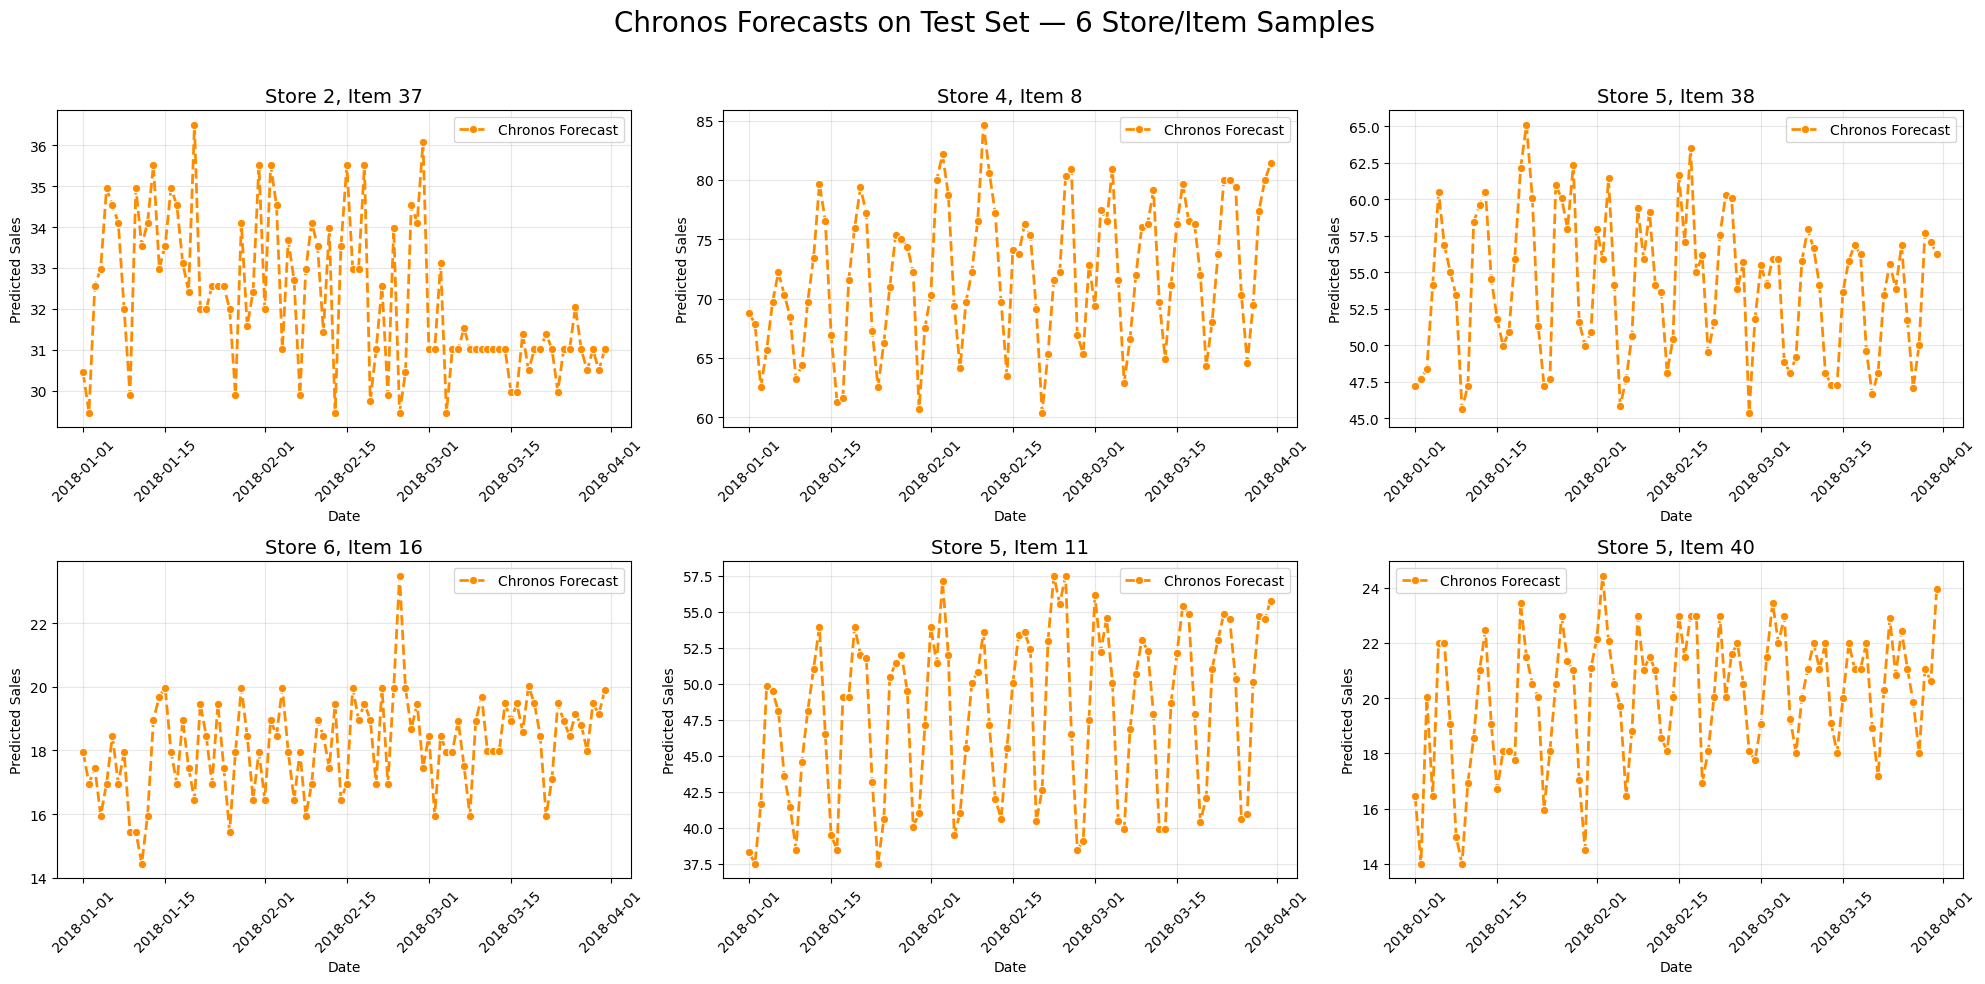

In [ ]:
# Randomly pick 6 (store, item) pairs
sample_viz_df = chronos_forecast_df[['store', 'item']].drop_duplicates().sample(6, random_state=42)

# Plot setup: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)

for ax, (_, row) in zip(axes.flatten(), sample_viz_df.iterrows()):
    store, item = row['store'], row['item']
    
    # Filter Chronos forecasted results
    plot_df = chronos_forecast_df[
        (chronos_forecast_df['store'] == store) &
        (chronos_forecast_df['item'] == item)
    ].sort_values("ds")

    # Plot predicted sales (Chronos)
    sns.lineplot(
        data=plot_df, x="ds", y="predicted_sales",
        marker='o', linestyle='--', color='darkorange',
        ax=ax, linewidth=2, label="Chronos Forecast"
    )

    ax.set_title(f"Store {store}, Item {item}", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Predicted Sales")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

fig.suptitle("Chronos Forecasts on Test Set — 6 Store/Item Samples", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



## Ensemble

< future plan >

Other Methods : Prophet, LSTM

## Conclusions

### Link : https://github.com/FRAMEEE17/Sales-Forecasting-Retails